In [1]:
from tensorflow import keras
import pickle
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import seaborn as sns
import pickle
import functools
import fastdtw
import scipy.spatial.distance as sd
import functools
import matplotlib.pyplot as plt
import seaborn as sns

2022-04-15 23:27:13.012714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 23:27:13.012744: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Importing solar and wind dataframes
solar_df = pd.read_csv('Final Datasets/solar_energy_generation.csv')
wind_df = pd.read_csv('Final Datasets/wind_energy_generation.csv')

In [3]:
# Removing unnecessary columns
solar_df = solar_df[['timestamp', 'GHI_KWh',
       'Clearsky GHI_KWh', 'Solar Energy', 'Clearsky Solar Energy']]
# Renaming columns for the lineplot
solar_df.rename(columns = {'GHI_KWh':'Global Horizontal Irradiance',
                          'Clearsky GHI_KWh': 'Clearsky Global Horizontal Irradiance'}, inplace = True)
# Converting timestamp from string to pd.datetime format
solar_df['timestamp'] = pd.to_datetime(solar_df['timestamp'])
# Limiting solar dataset to 2017
solar_df = solar_df[solar_df['timestamp'] >= pd.Timestamp("2020-01-01 00:00:00")]
solar_df = solar_df[solar_df['timestamp'] < pd.Timestamp("2021-01-01 00:00:00")]
# Setting the index to timestamp
solar_df = solar_df.set_index('timestamp')
solar_df

Global Horizontal Irradiance  \
timestamp                                           
2020-01-01 00:00:00                           0.0   
2020-01-01 00:30:00                           0.0   
2020-01-01 01:00:00                           0.0   
2020-01-01 01:30:00                           0.0   
2020-01-01 02:00:00                           0.0   
...                                           ...   
2020-12-31 21:30:00                           0.0   
2020-12-31 22:00:00                           0.0   
2020-12-31 22:30:00                           0.0   
2020-12-31 23:00:00                           0.0   
2020-12-31 23:30:00                           0.0   

                     Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                                  
2020-01-01 00:00:00                                    0.0           0.0   
2020-01-01 00:30:00                                    0.0           0.0   
2020-01-01 01:00:00                                    0.0           0.0   
2020-01-01 01:30:00                                    0.0           0.0   
2020-01-01 02:00:00                                    0.0           0.0   
...                                                    ...           ...   
2020-12-31 21:30:00                                    0.0           0.0   
2020-12-31 22:00:00                                    0.0           0.0   
2020-12-31 22:30:00                                    0.0           0.0   
2020-12-31 23:00:00                                    0.0           0.0   
2020-12-31 23:30:00                                    0.0           0.0   

                     Clearsky Solar Energy  
timestamp                                   
2020-01-01 00:00:00                    0.0  
2020-01-01 00:30:00                    0.0  
2020-01-01 01:00:00                    0.0  
2020-01-01 01:30:00                    0.0  
2020-01-01 02:00:00                    0.0  
...                                    ...  
2020-12-31 21:30:00                    0.0  
2020-12-31 22:00:00                    0.0  
2020-12-31 22:30:00                    0.0  
2020-12-31 23:00:00                    0.0  
2020-12-31 23:30:00                    0.0  

[17568 rows x 4 columns]

In [4]:
# I have used this post on Stackoverflow to plot multiple graphs 
# https://stackoverflow.com/a/38305181
def plot_solar(df, size=(8, 6)):
    figs = {}
    axs = {}
    for idx, feature in enumerate(df.keys()):
        figs[idx] = plt.figure(figsize = size)
        axs[idx] = figs[idx].add_subplot(111)
        axs[idx].plot(df[feature], label=feature)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel('KWh')
        axs[idx].legend()
    return figs, axs

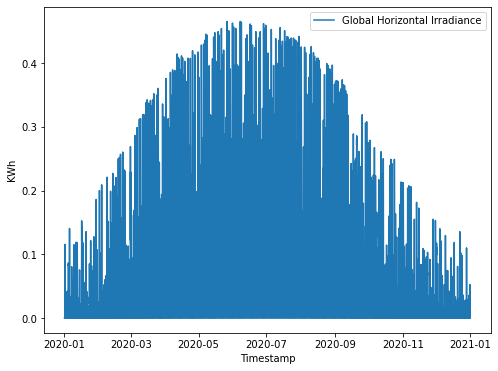

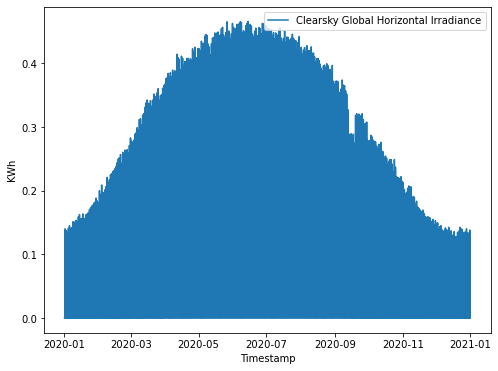

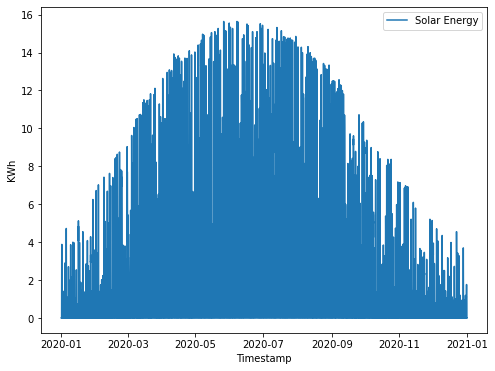

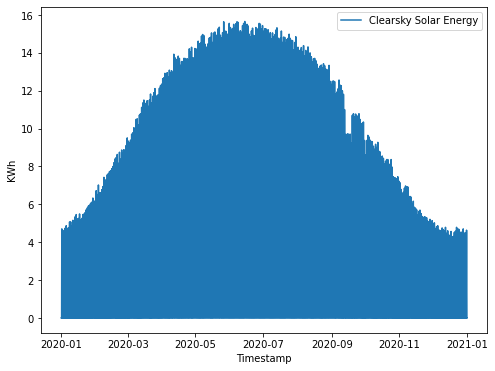

In [5]:
# Plotting line graphs on an annual scale
figs, axs = plot_solar(solar_df)

In [6]:
# Aggregating solar df to weekly datapoints and summing values for each week
solar_df
#solar_weekly_df = solar_df.resample('D').sum()
solar_weekly_df = solar_df.resample('W').sum()
solar_weekly_df.head()

Global Horizontal Irradiance  \
timestamp                                  
2020-01-05                        3.0340   
2020-01-12                        4.3970   
2020-01-19                        4.0860   
2020-01-26                        3.7265   
2020-02-02                        6.7045   

            Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                         
2020-01-05                                 6.9290      101.9424   
2020-01-12                                10.4575      147.7392   
2020-01-19                                11.4975      137.2896   
2020-01-26                                12.7470      125.2104   
2020-02-02                                14.5900      225.2712   

            Clearsky Solar Energy  
timestamp                          
2020-01-05               232.8144  
2020-01-12               351.3720  
2020-01-19               386.3160  
2020-01-26               428.2992  
2020-02-02               490.2240

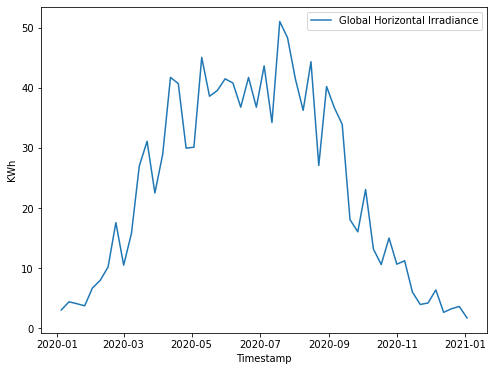

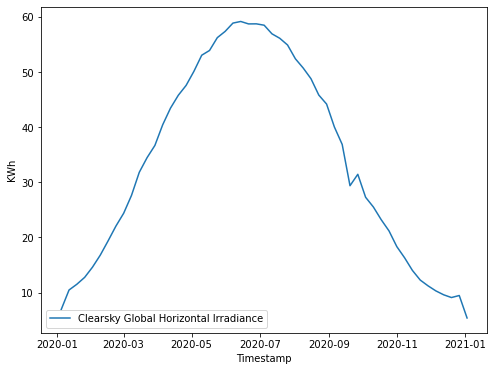

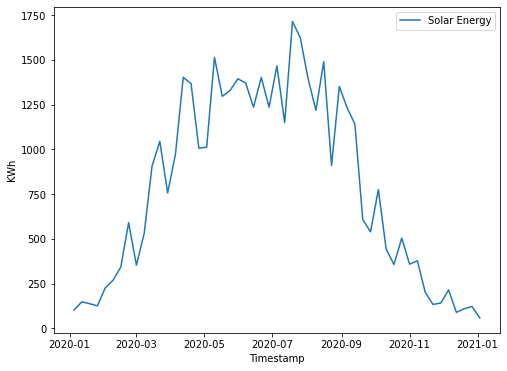

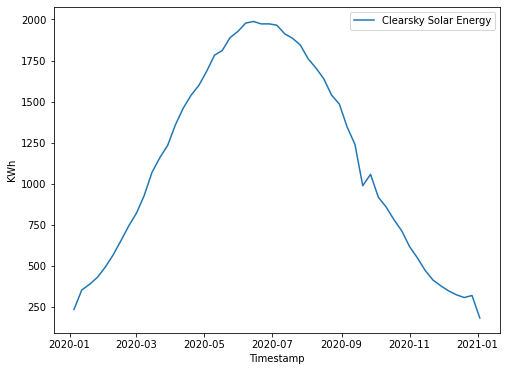

In [7]:
# Plotting annual line graphs with aggregated weekly datapoints
figs, axs = plot_solar(solar_weekly_df)

In [8]:
# Limiting solar df to Nov 2017: November 2017 Energy Consumption values are common for all houses except 4
solar_df = solar_df[solar_df.index >= pd.Timestamp("2020-11-01 00:00:00")]
solar_df = solar_df[solar_df.index < pd.Timestamp("2020-12-01 00:00:00")]
solar_df

Global Horizontal Irradiance  \
timestamp                                           
2020-11-01 00:00:00                           0.0   
2020-11-01 00:30:00                           0.0   
2020-11-01 01:00:00                           0.0   
2020-11-01 01:30:00                           0.0   
2020-11-01 02:00:00                           0.0   
...                                           ...   
2020-11-30 21:30:00                           0.0   
2020-11-30 22:00:00                           0.0   
2020-11-30 22:30:00                           0.0   
2020-11-30 23:00:00                           0.0   
2020-11-30 23:30:00                           0.0   

                     Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                                  
2020-11-01 00:00:00                                    0.0           0.0   
2020-11-01 00:30:00                                    0.0           0.0   
2020-11-01 01:00:00                                    0.0           0.0   
2020-11-01 01:30:00                                    0.0           0.0   
2020-11-01 02:00:00                                    0.0           0.0   
...                                                    ...           ...   
2020-11-30 21:30:00                                    0.0           0.0   
2020-11-30 22:00:00                                    0.0           0.0   
2020-11-30 22:30:00                                    0.0           0.0   
2020-11-30 23:00:00                                    0.0           0.0   
2020-11-30 23:30:00                                    0.0           0.0   

                     Clearsky Solar Energy  
timestamp                                   
2020-11-01 00:00:00                    0.0  
2020-11-01 00:30:00                    0.0  
2020-11-01 01:00:00                    0.0  
2020-11-01 01:30:00                    0.0  
2020-11-01 02:00:00                    0.0  
...                                    ...  
2020-11-30 21:30:00                    0.0  
2020-11-30 22:00:00                    0.0  
2020-11-30 22:30:00                    0.0  
2020-11-30 23:00:00                    0.0  
2020-11-30 23:30:00                    0.0  

[1440 rows x 4 columns]

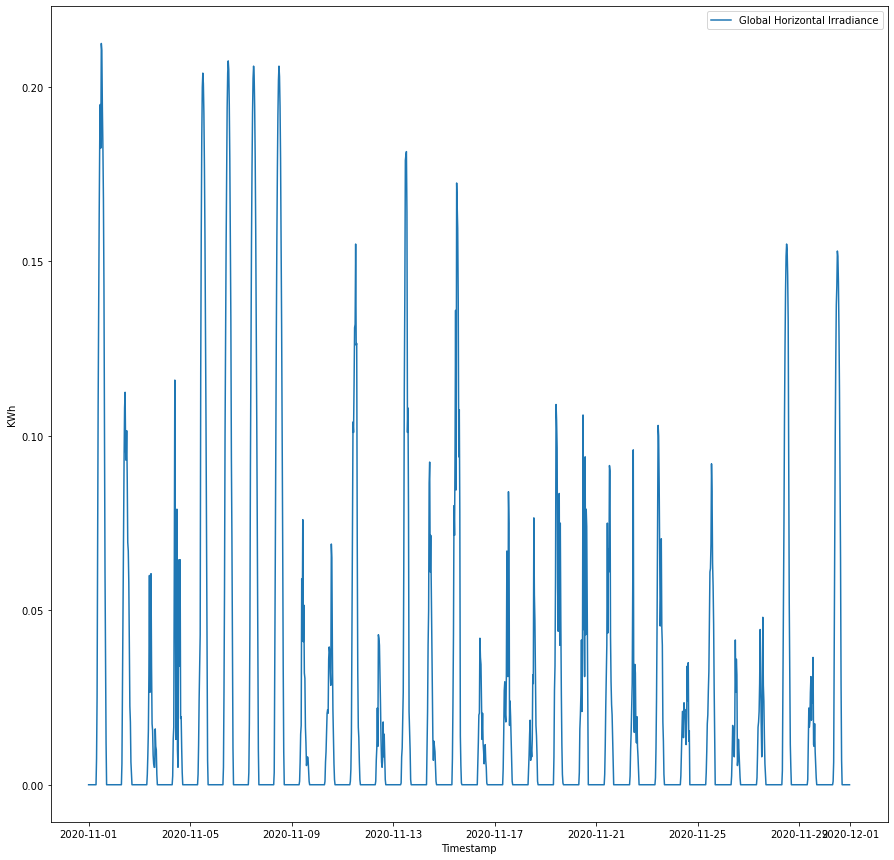

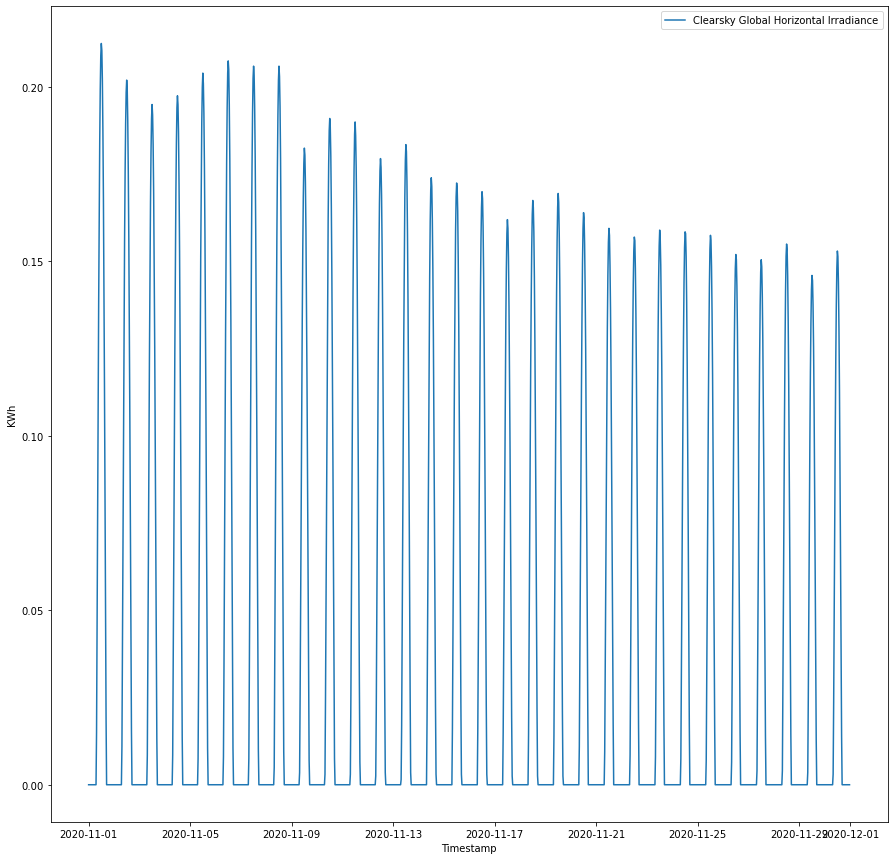

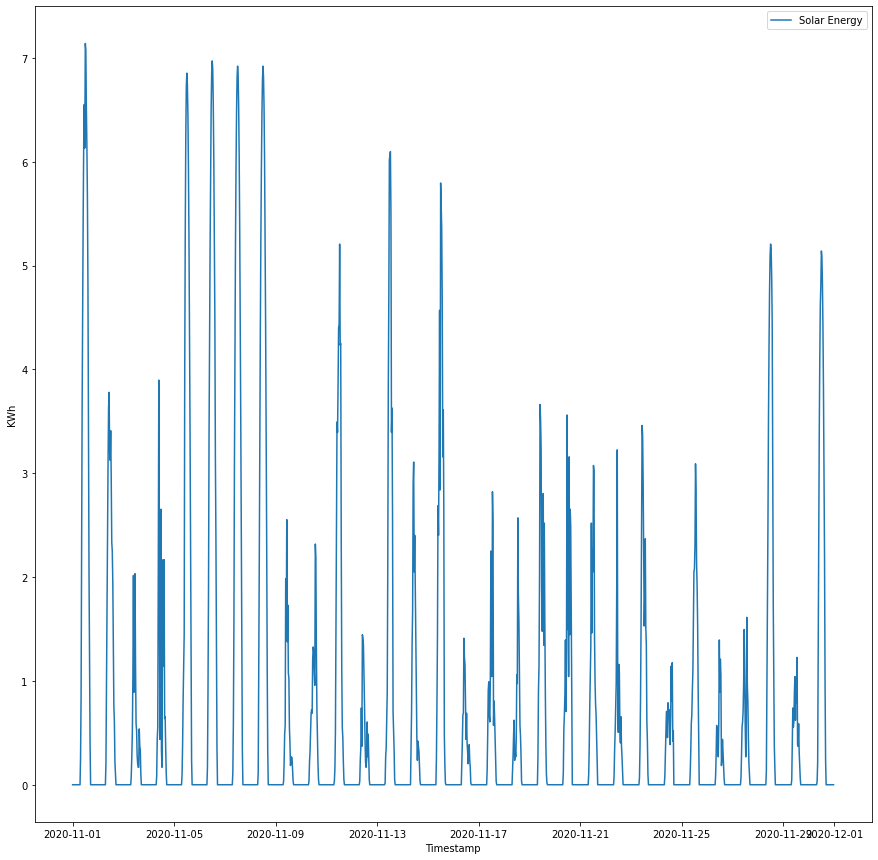

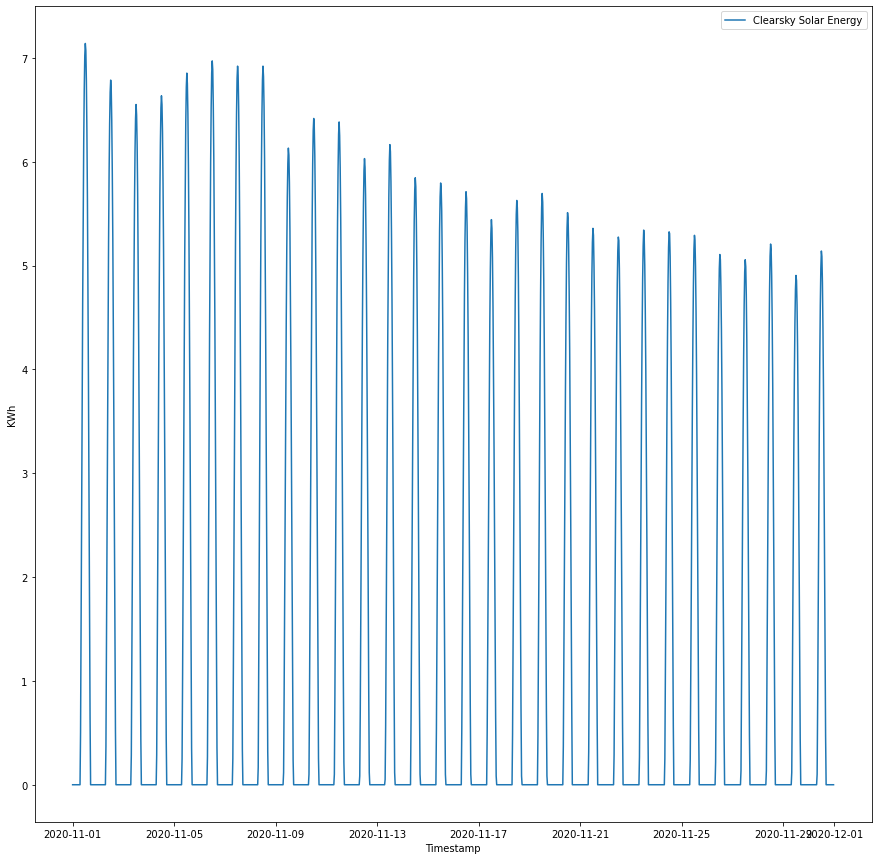

In [9]:
# Plotting line graphs for December 2017
figs, axs = plot_solar(solar_df, (15,15))

In [10]:
# Aggregating data points at every 6 hours
solar_df
solar_six_hour_df = solar_df.resample('6H').sum()
solar_six_hour_df

Global Horizontal Irradiance  \
timestamp                                           
2020-11-01 00:00:00                        0.0000   
2020-11-01 06:00:00                        1.0715   
2020-11-01 12:00:00                        1.3260   
2020-11-01 18:00:00                        0.0000   
2020-11-02 00:00:00                        0.0000   
...                                           ...   
2020-11-29 18:00:00                        0.0000   
2020-11-30 00:00:00                        0.0000   
2020-11-30 06:00:00                        0.6250   
2020-11-30 12:00:00                        0.8835   
2020-11-30 18:00:00                        0.0000   

                     Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                                  
2020-11-01 00:00:00                                 0.0000        0.0000   
2020-11-01 06:00:00                                 1.1375       36.0024   
2020-11-01 12:00:00                                 1.3875       44.5536   
2020-11-01 18:00:00                                 0.0000        0.0000   
2020-11-02 00:00:00                                 0.0000        0.0000   
...                                                    ...           ...   
2020-11-29 18:00:00                                 0.0000        0.0000   
2020-11-30 00:00:00                                 0.0000        0.0000   
2020-11-30 06:00:00                                 0.6600       21.0000   
2020-11-30 12:00:00                                 0.9000       29.6856   
2020-11-30 18:00:00                                 0.0000        0.0000   

                     Clearsky Solar Energy  
timestamp                                   
2020-11-01 00:00:00                  0.000  
2020-11-01 06:00:00                 38.220  
2020-11-01 12:00:00                 46.620  
2020-11-01 18:00:00                  0.000  
2020-11-02 00:00:00                  0.000  
...                                    ...  
2020-11-29 18:00:00                  0.000  
2020-11-30 00:00:00                  0.000  
2020-11-30 06:00:00                 22.176  
2020-11-30 12:00:00                 30.240  
2020-11-30 18:00:00                  0.000  

[120 rows x 4 columns]

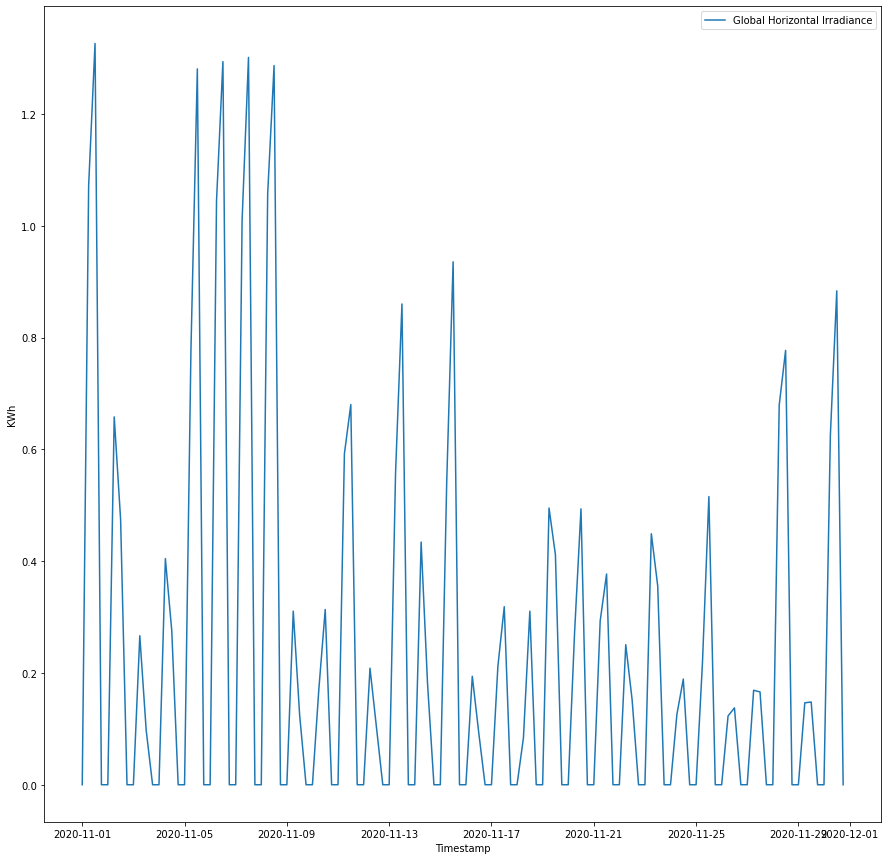

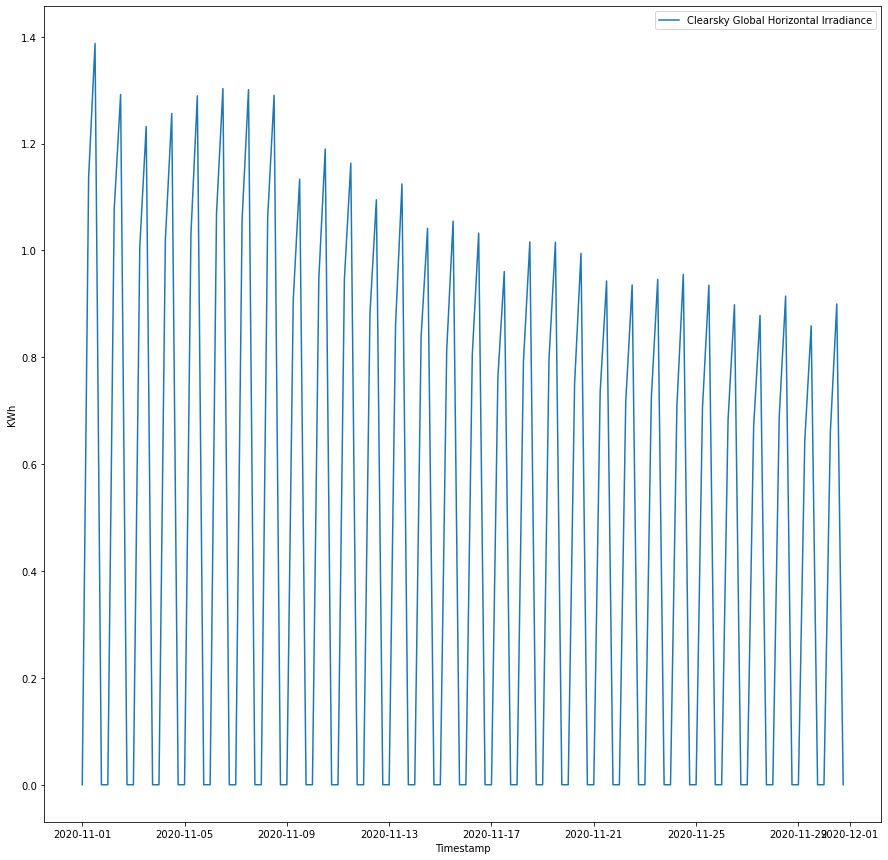

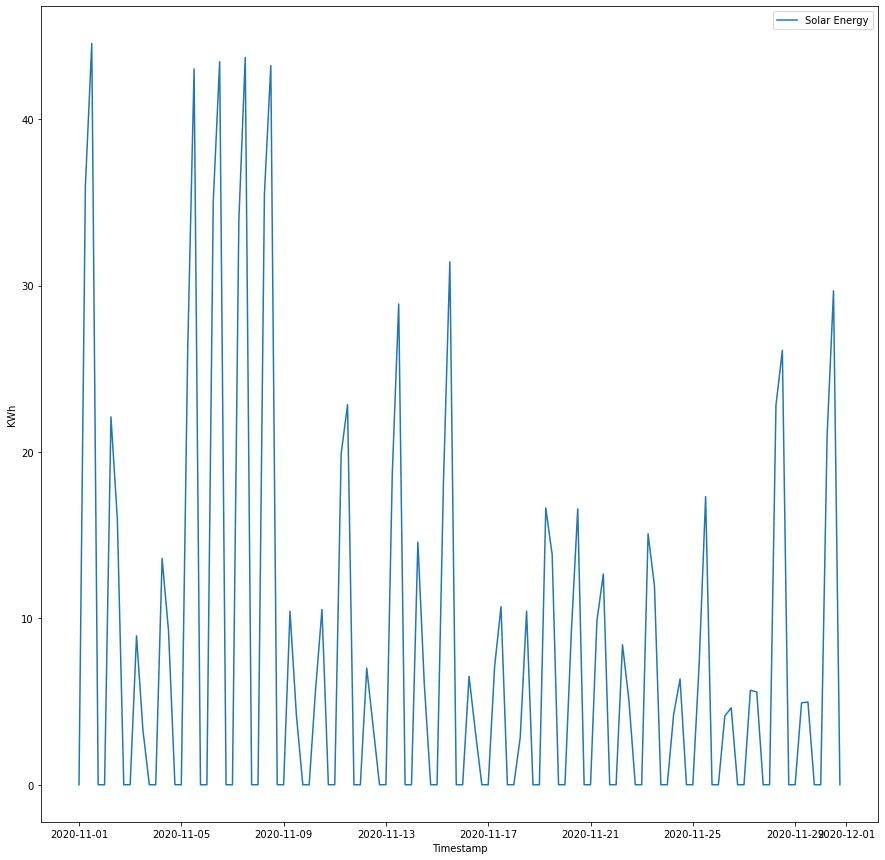

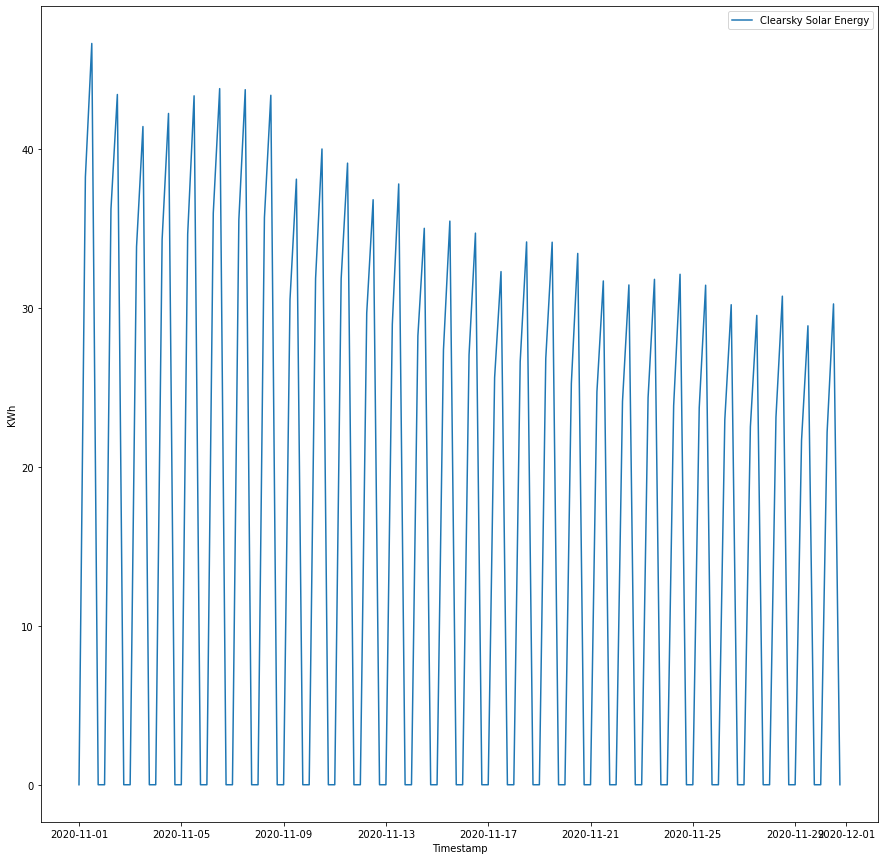

In [11]:
# Plotting monthly line graphs with aggregated datapoints
figs, axs = plot_solar(solar_six_hour_df, (15,15))

### Wind Dataframe Graphs

In [12]:
wind_df

Unnamed: 0            timestamp  Pressure  Temperature  Wind Speed  \
0                0  2012-01-01 00:00:00    102000       275.15         0.5   
1                1  2012-01-01 00:30:00    102000       275.15         0.5   
2                2  2012-01-01 01:00:00    102000       275.15         0.5   
3                3  2012-01-01 01:30:00    102000       275.15         0.5   
4                4  2012-01-01 02:00:00    102000       275.15         0.5   
...            ...                  ...       ...          ...         ...   
157819      157819  2020-12-31 21:30:00    100200       282.95         1.0   
157820      157820  2020-12-31 22:00:00    100200       283.05         1.0   
157821      157821  2020-12-31 22:30:00    100200       283.05         1.0   
157822      157822  2020-12-31 23:00:00    100200       282.95         1.0   
157823      157823  2020-12-31 23:30:00    100300       282.85         1.0   

        Air Density    Wind Power  Wind Energy  
0          1.291401   4711.409041     2.355705  
1          1.291401   4711.409041     2.355705  
2          1.291401   4711.409041     2.355705  
3          1.291401   4711.409041     2.355705  
4          1.291401   4711.409041     2.355705  
...             ...           ...          ...  
157819     1.233640  36005.443653    18.002722  
157820     1.233204  35992.723129    17.996362  
157821     1.233204  35992.723129    17.996362  
157822     1.233640  36005.443653    18.002722  
157823     1.235308  36054.119452    18.027060  

[157824 rows x 8 columns]

In [13]:
# Removing unnecessary columns
wind_df = wind_df[['timestamp', 'Pressure', 'Temperature', 'Wind Speed',
       'Air Density', 'Wind Power', 'Wind Energy']]
# Units of the features in the dataframe for y-labels
wind_feature_units = {'timestamp': 'time', 'Pressure':'Pa', 'Temperature':'Kelvin', 'Wind Speed':'m/s',
       'Air Density':'kg/m^3', 'Wind Power':'Watt', 'Wind Energy':'KWh'}
# Converting timestamp from string to pd.datetime format
wind_df['timestamp'] = pd.to_datetime(wind_df['timestamp'])
# Limiting wind dataset to 2017
wind_df = wind_df[wind_df['timestamp'] >= pd.Timestamp("2020-01-01 00:00:00")]
wind_df = wind_df[wind_df['timestamp'] < pd.Timestamp("2021-01-01 00:00:00")]
# Setting the index to timestamp
wind_df = wind_df.set_index('timestamp')
wind_df

/tmp/ipykernel_123475/447207535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_df['timestamp'] = pd.to_datetime(wind_df['timestamp'])


Pressure  Temperature  Wind Speed  Air Density  \
timestamp                                                             
2020-01-01 00:00:00    100300       282.85         1.0     1.235308   
2020-01-01 00:30:00    100300       282.65         1.0     1.236182   
2020-01-01 01:00:00    100300       282.55         1.0     1.236619   
2020-01-01 01:30:00    100300       282.35         1.1     1.237495   
2020-01-01 02:00:00    100400       282.15         1.1     1.239607   
...                       ...          ...         ...          ...   
2020-12-31 21:30:00    100200       282.95         1.0     1.233640   
2020-12-31 22:00:00    100200       283.05         1.0     1.233204   
2020-12-31 22:30:00    100200       283.05         1.0     1.233204   
2020-12-31 23:00:00    100200       282.95         1.0     1.233640   
2020-12-31 23:30:00    100300       282.85         1.0     1.235308   

                       Wind Power  Wind Energy  
timestamp                                       
2020-01-01 00:00:00  36054.119452    18.027060  
2020-01-01 00:30:00  36079.630947    18.039815  
2020-01-01 01:00:00  36092.400237    18.046200  
2020-01-01 01:30:00  48073.012685    24.036506  
2020-01-01 02:00:00  48155.052094    24.077526  
...                           ...          ...  
2020-12-31 21:30:00  36005.443653    18.002722  
2020-12-31 22:00:00  35992.723129    17.996362  
2020-12-31 22:30:00  35992.723129    17.996362  
2020-12-31 23:00:00  36005.443653    18.002722  
2020-12-31 23:30:00  36054.119452    18.027060  

[17568 rows x 6 columns]

In [14]:
# I have used this post on Stackoverflow to plot multiple graphs 
# https://stackoverflow.com/a/38305181
def plot_wind(df, units, size=(8, 6)):
    figs = {}
    axs = {}
    for idx, feature in enumerate(df.keys()):
        figs[idx] = plt.figure(figsize = size)
        axs[idx] = figs[idx].add_subplot(111)
        axs[idx].plot(df[feature], label=feature)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel(units[feature])
        axs[idx].legend()
    return figs, axs

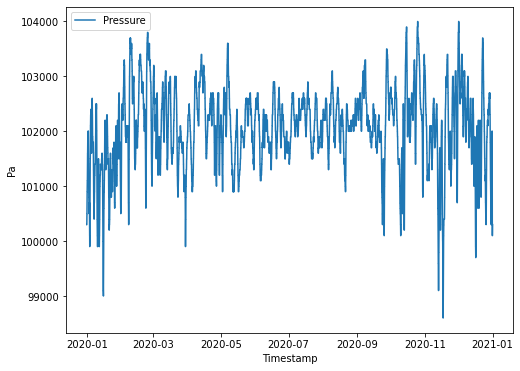

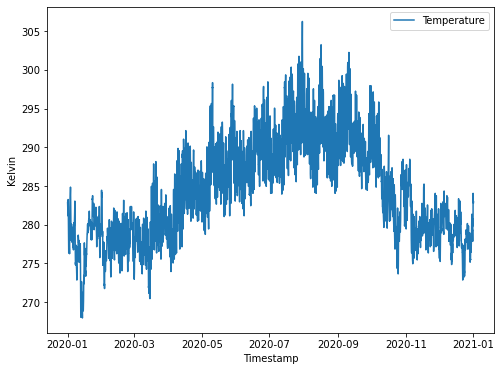

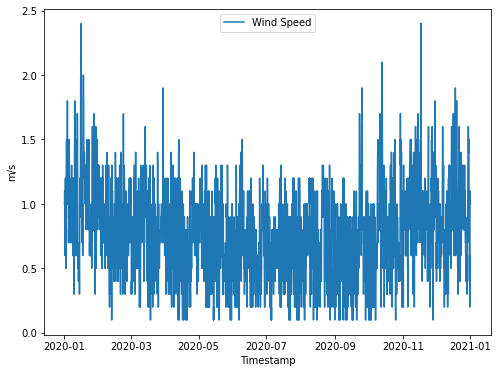

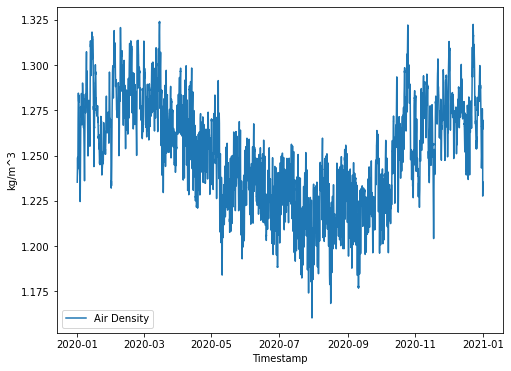

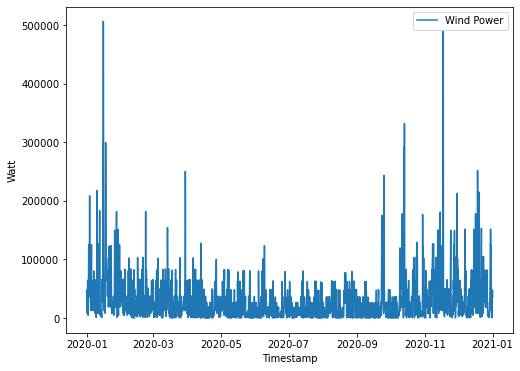

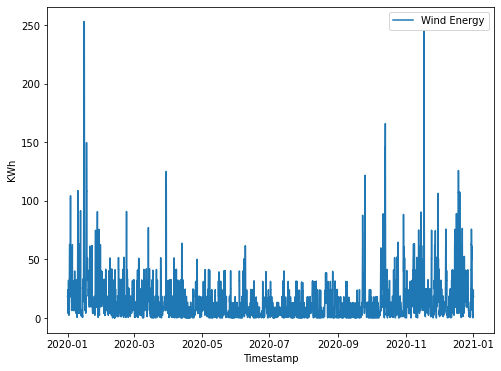

In [15]:
# Plotting line graphs on an annual scale
figs, axs = plot_wind(wind_df, wind_feature_units)

In [16]:
# Aggregating wind df to weekly datapoints and summing values for each week

wind_weekly_df = wind_df.resample('W').sum()
# Removing the first row because of incorrect values 
wind_weekly_df = wind_weekly_df.iloc[1: , :]

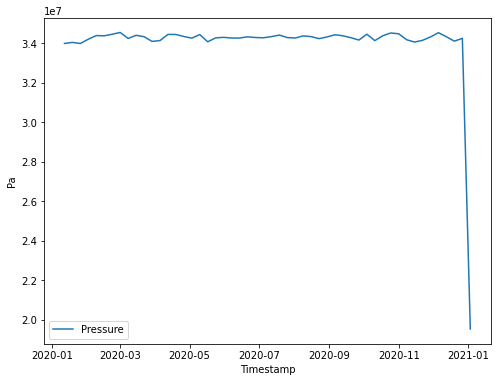

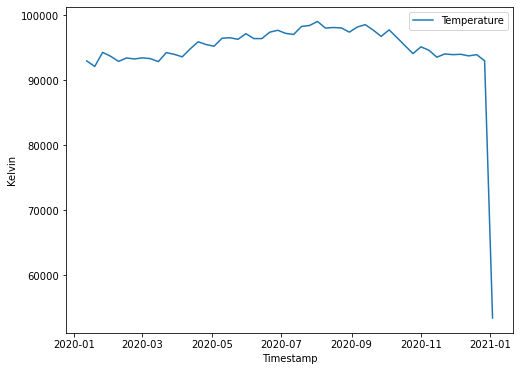

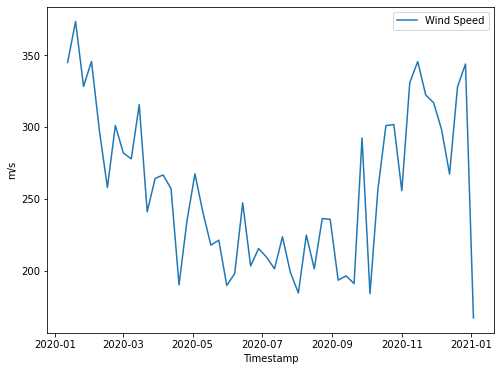

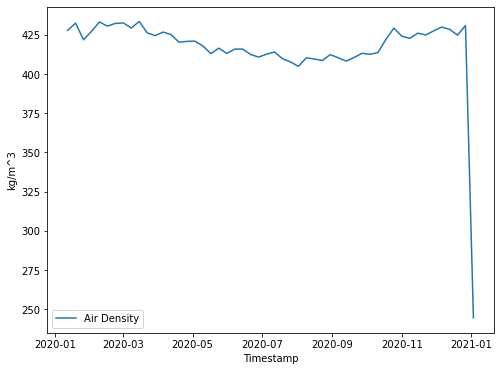

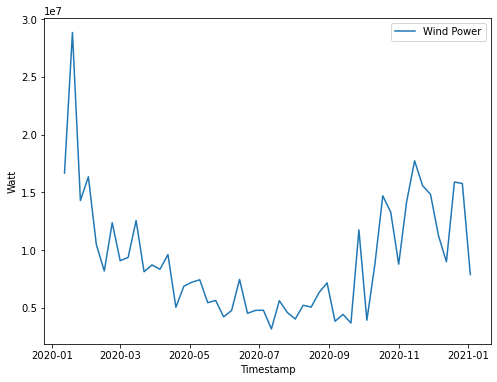

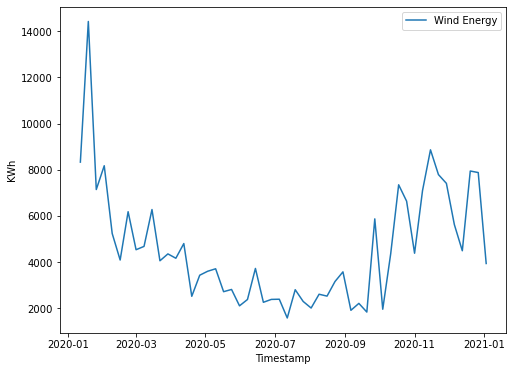

In [17]:
# Plotting annual line graphs with aggregated weekly datapoints
figs, axs = plot_wind(wind_weekly_df, wind_feature_units)

In [18]:
# Limiting wind df to November 2017
wind_df = wind_df[wind_df.index >= pd.Timestamp("2020-11-01 00:00:00")]
wind_df = wind_df[wind_df.index < pd.Timestamp("2020-12-01 00:00:00")]
wind_df

Pressure  Temperature  Wind Speed  Air Density  \
timestamp                                                             
2020-11-01 00:00:00    103100       280.85         0.9     1.278835   
2020-11-01 00:30:00    103100       280.75         0.9     1.279291   
2020-11-01 01:00:00    103100       280.55         1.0     1.280203   
2020-11-01 01:30:00    103100       280.35         1.1     1.281116   
2020-11-01 02:00:00    103100       280.25         1.1     1.281573   
...                       ...          ...         ...          ...   
2020-11-30 21:30:00    103400       276.85         1.3     1.301087   
2020-11-30 22:00:00    103400       276.85         1.3     1.301087   
2020-11-30 22:30:00    103500       276.95         1.2     1.301875   
2020-11-30 23:00:00    103500       277.05         1.2     1.301405   
2020-11-30 23:30:00    103600       276.95         1.2     1.303133   

                       Wind Power  Wind Energy  
timestamp                                       
2020-11-01 00:00:00  27209.584420    13.604792  
2020-11-01 00:30:00  27219.276169    13.609638  
2020-11-01 01:00:00  37364.444984    18.682222  
2020-11-01 01:30:00  49767.554837    24.883777  
2020-11-01 02:00:00  49785.313108    24.892657  
...                           ...          ...  
2020-11-30 21:30:00  83428.841152    41.714421  
2020-11-30 22:00:00  83428.841152    41.714421  
2020-11-30 22:30:00  65658.787999    32.829394  
2020-11-30 23:00:00  65635.088743    32.817544  
2020-11-30 23:30:00  65722.226441    32.861113  

[1440 rows x 6 columns]

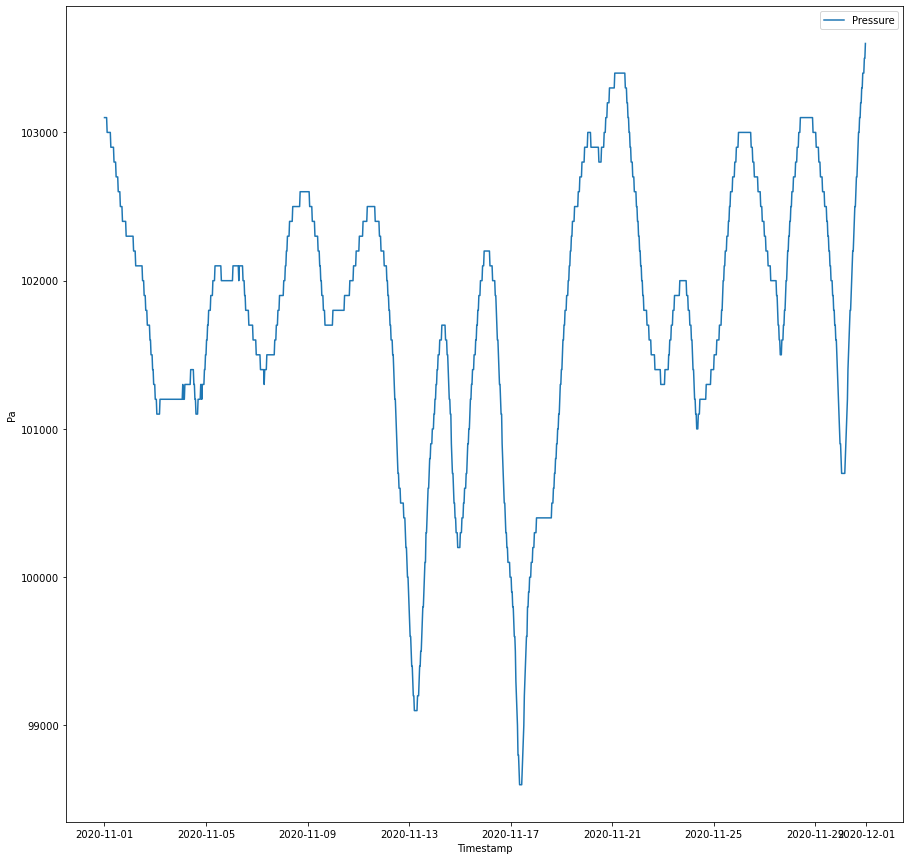

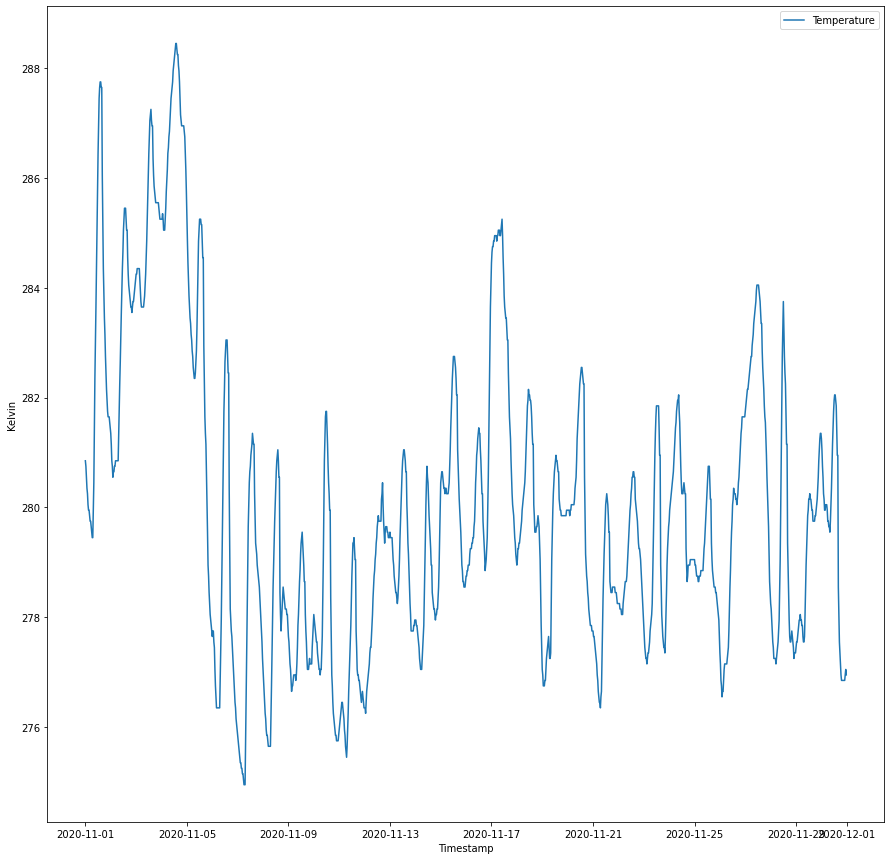

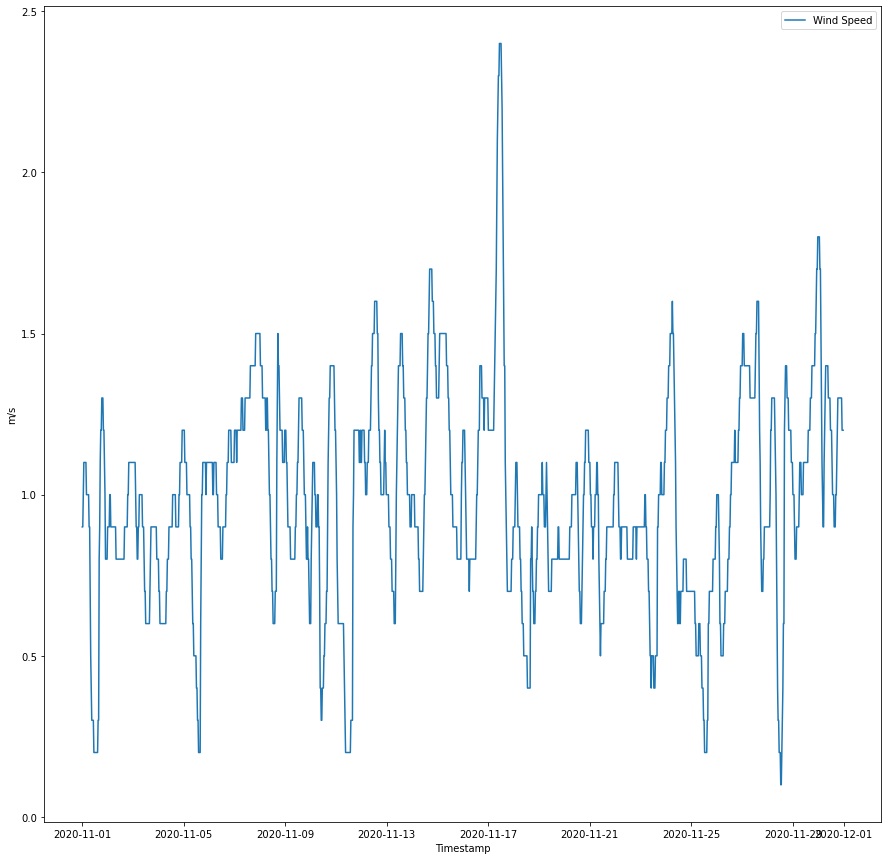

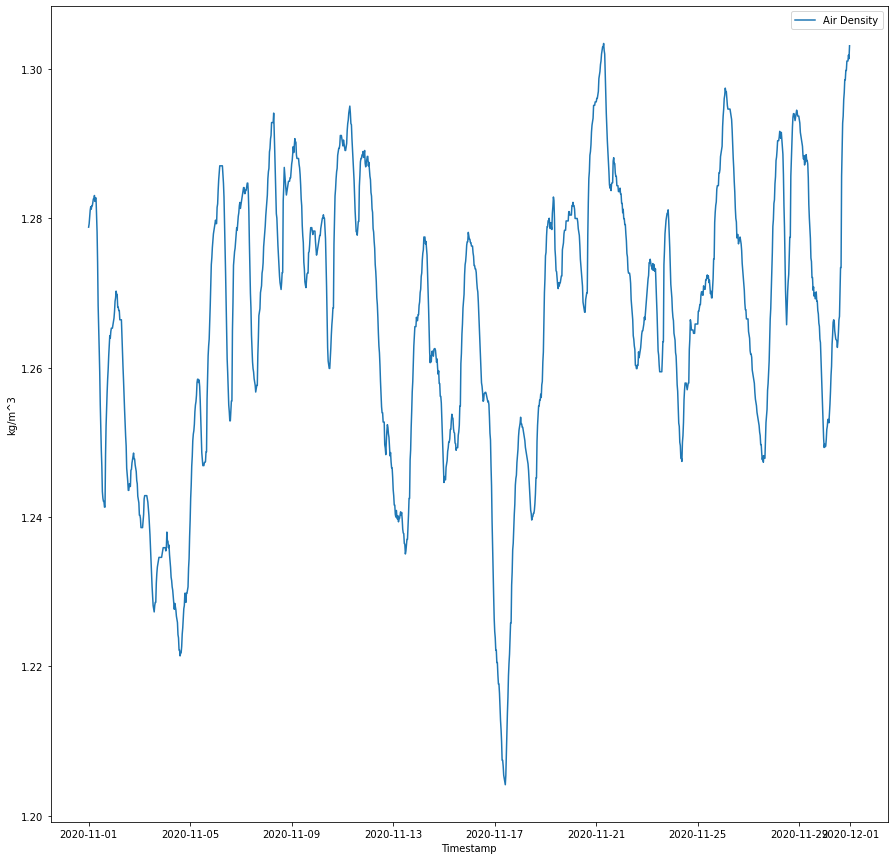

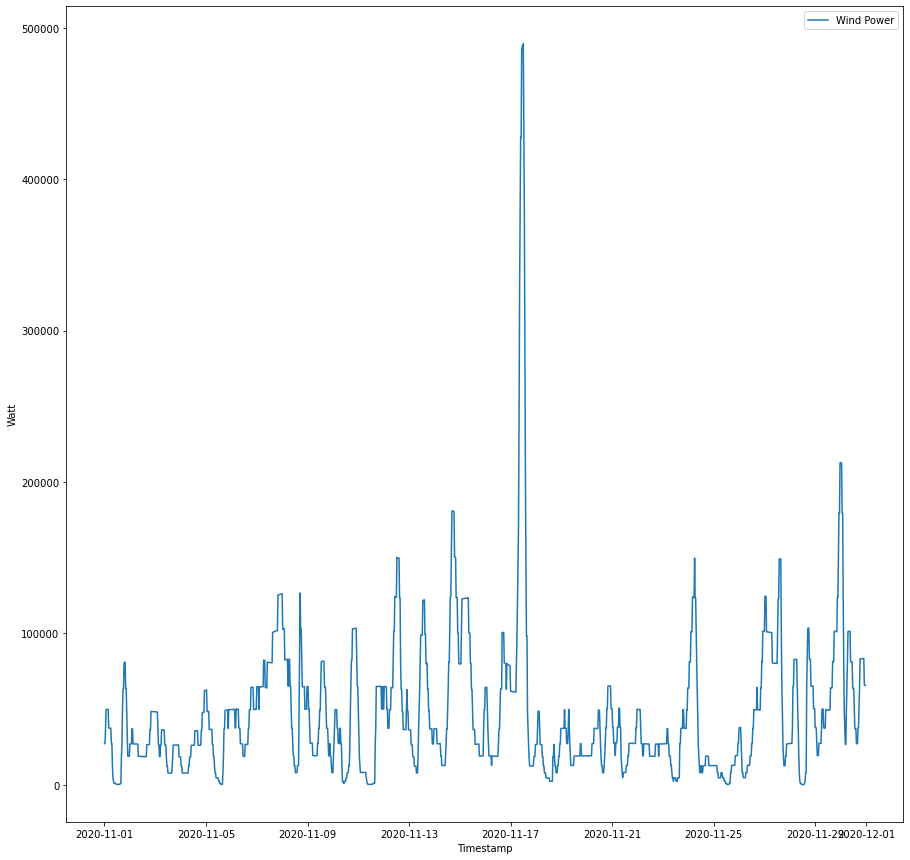

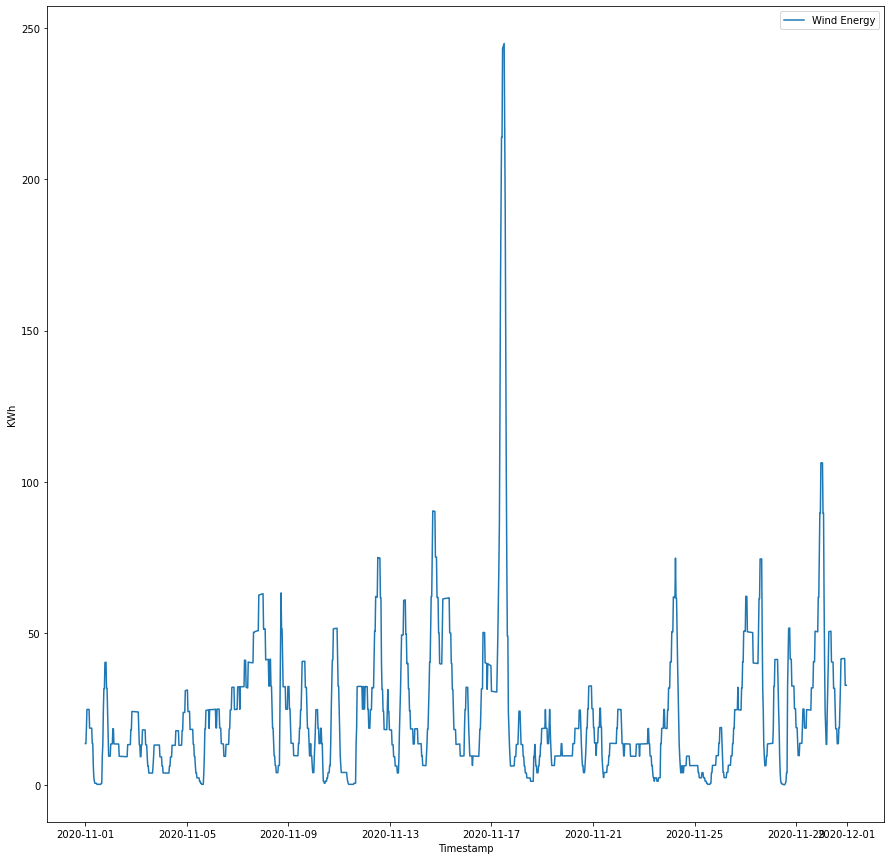

In [19]:
# Plotting line graphs for December 2017
figs, axs = plot_wind(wind_df, wind_feature_units, (15,15))

In [20]:
# Aggregating data points at every 6 hours
wind_df
wind_six_hour_df = wind_df.resample('6H').sum()
wind_six_hour_df

Pressure  Temperature  Wind Speed  Air Density  \
timestamp                                                             
2020-11-01 00:00:00   1236500       3361.7        12.3    15.376140   
2020-11-01 06:00:00   1234000       3384.3         6.0    15.243576   
2020-11-01 12:00:00   1230600       3438.7         5.8    14.960381   
2020-11-01 18:00:00   1228100       3385.6        12.8    15.163921   
2020-11-02 00:00:00   1227000       3370.0        11.0    15.220415   
...                       ...          ...         ...          ...   
2020-11-29 18:00:00   1216800       3366.6        18.2    15.109271   
2020-11-30 00:00:00   1209300       3364.0        16.6    15.027635   
2020-11-30 06:00:00   1220300       3363.6        15.9    15.166095   
2020-11-30 12:00:00   1231600       3364.6        12.3    15.302868   
2020-11-30 18:00:00   1240000       3323.0        15.2    15.599224   

                       Wind Power  Wind Energy  
timestamp                                       
2020-11-01 00:00:00  4.904392e+05   245.219591  
2020-11-01 06:00:00  1.164423e+05    58.221156  
2020-11-01 12:00:00  1.611127e+05    80.556358  
2020-11-01 18:00:00  5.953652e+05   297.682577  
2020-11-02 00:00:00  3.439333e+05   171.966643  
...                           ...          ...  
2020-11-29 18:00:00  1.576927e+06   788.463307  
2020-11-30 00:00:00  1.388013e+06   694.006573  
2020-11-30 06:00:00  1.038957e+06   519.478323  
2020-11-30 12:00:00  4.947150e+05   247.357522  
2020-11-30 18:00:00  9.290485e+05   464.524231  

[120 rows x 6 columns]

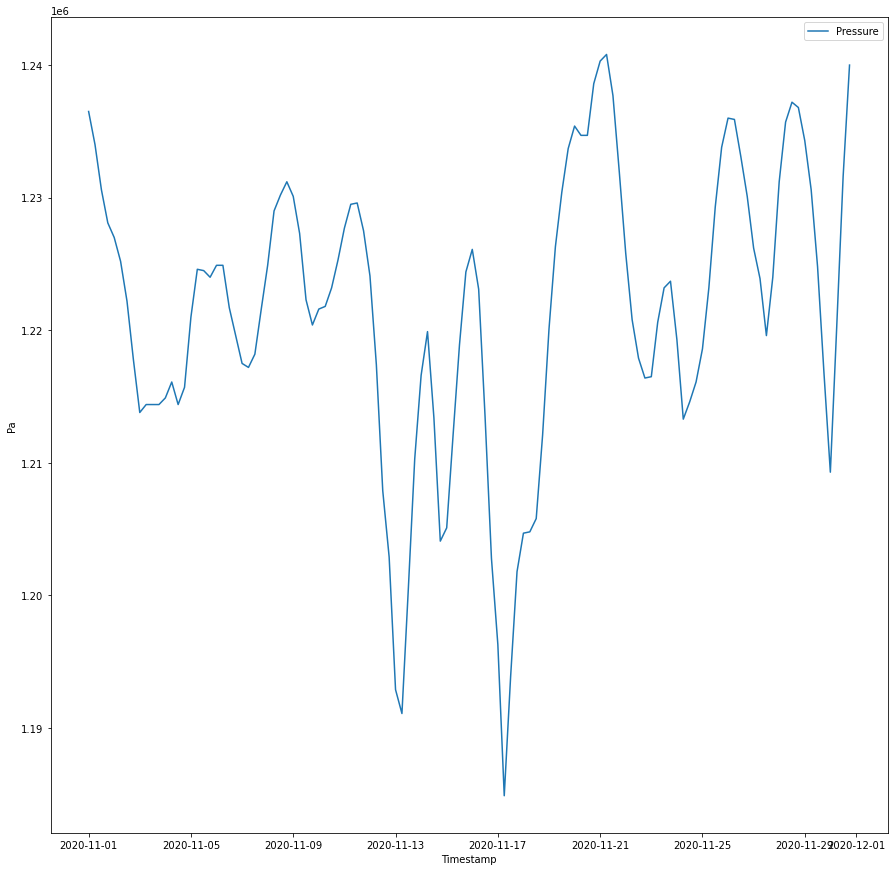

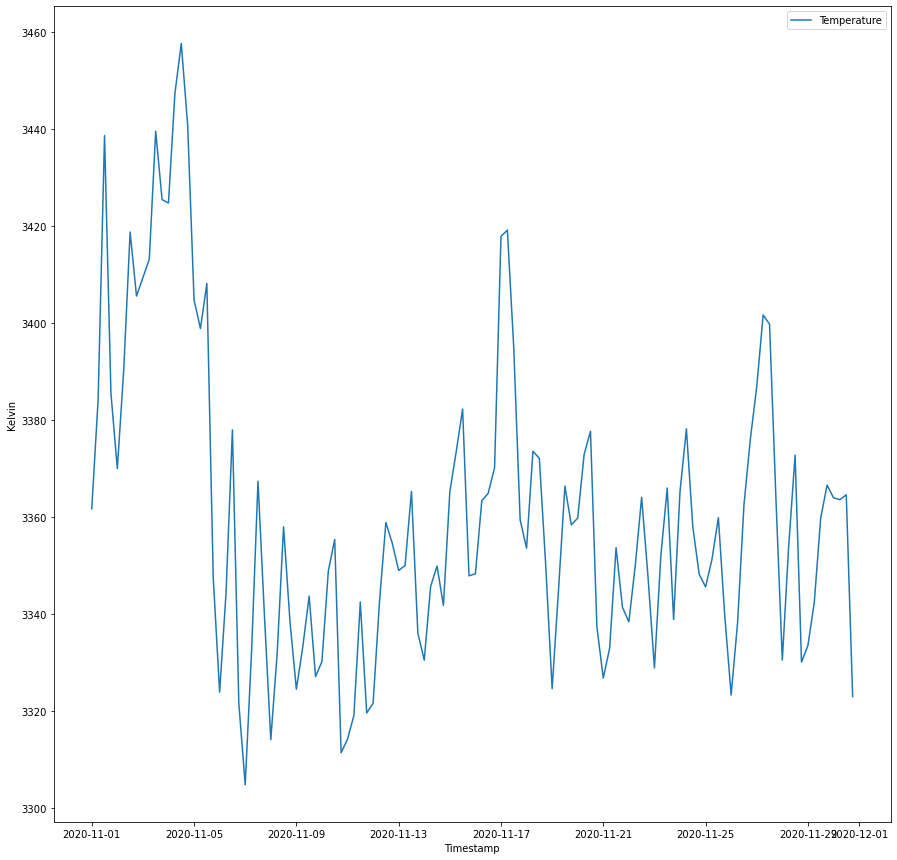

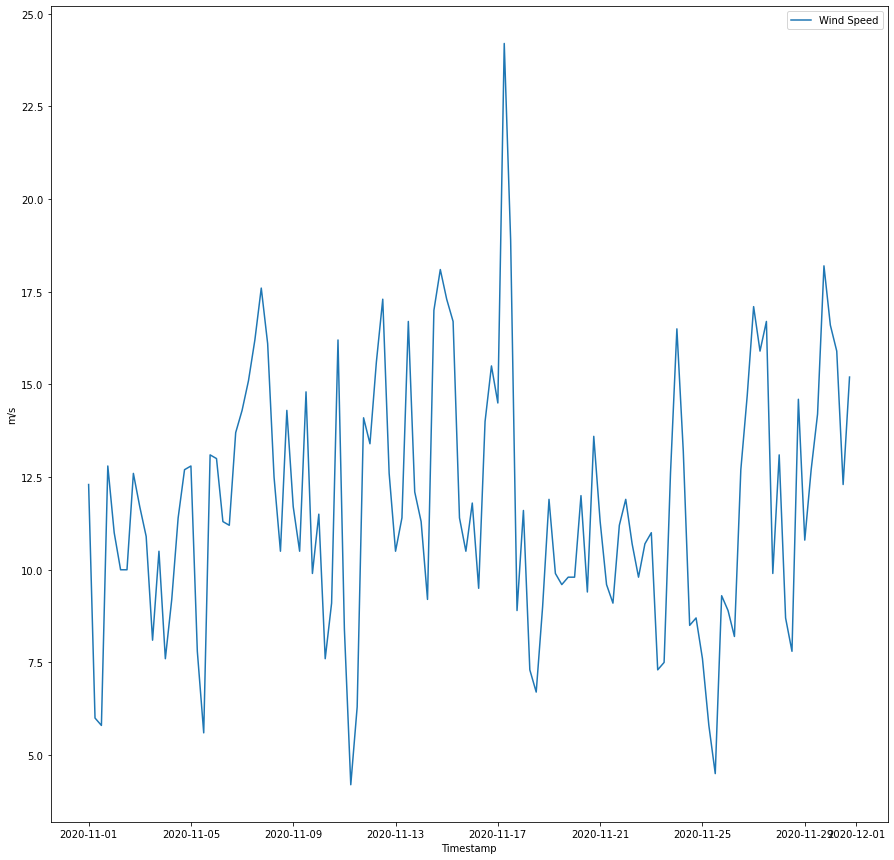

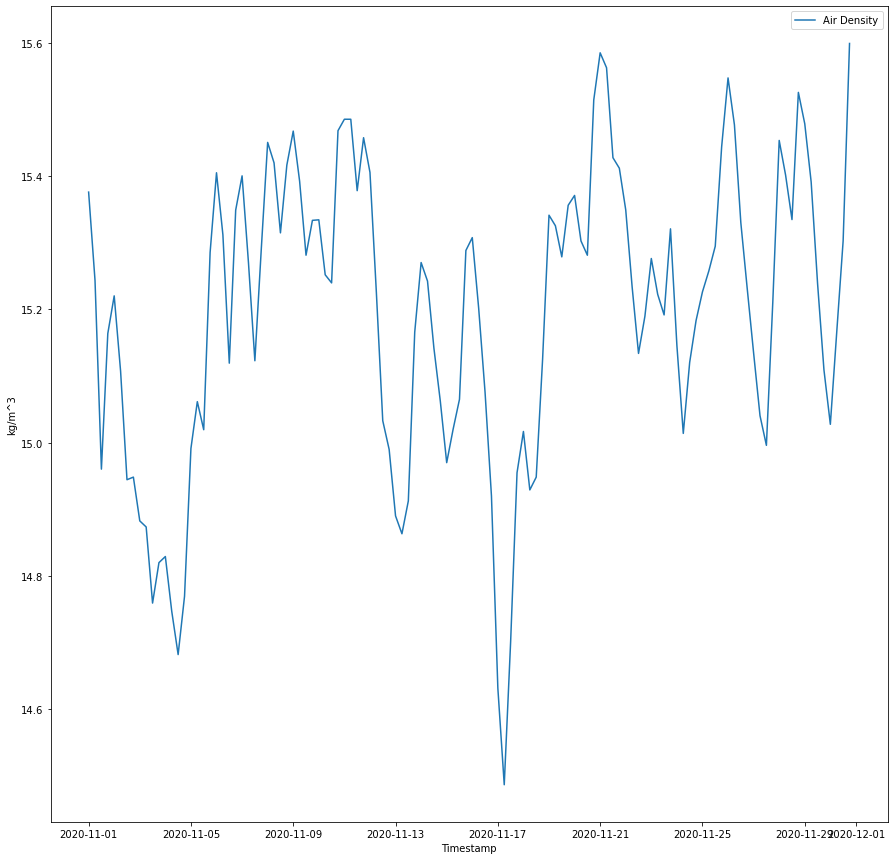

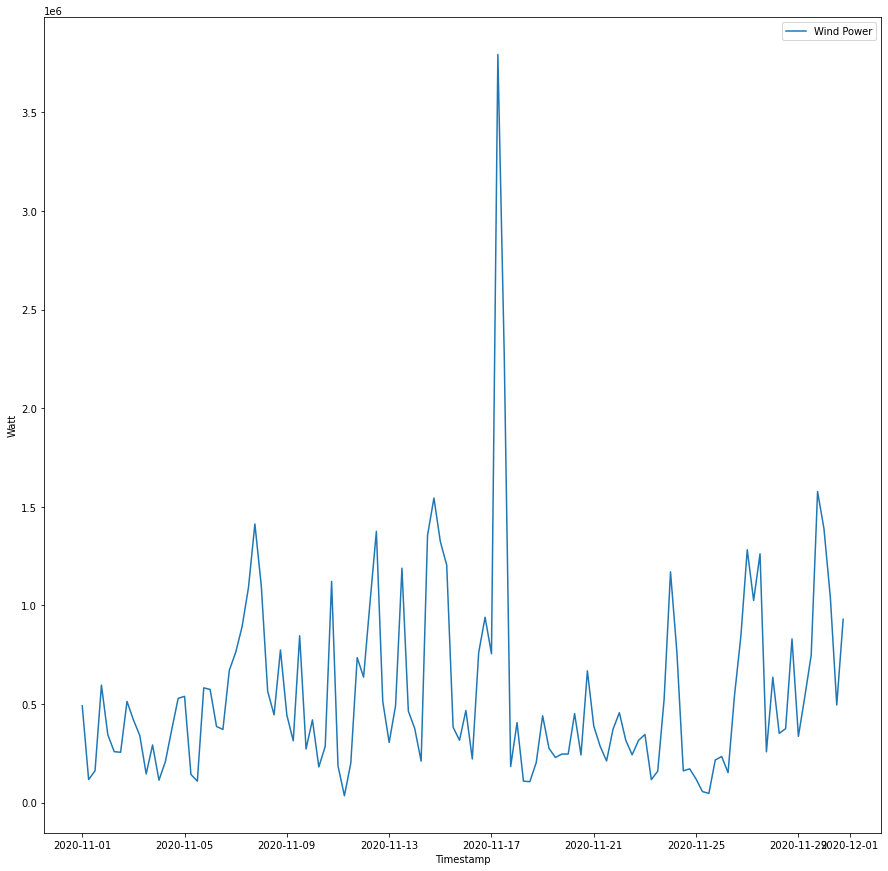

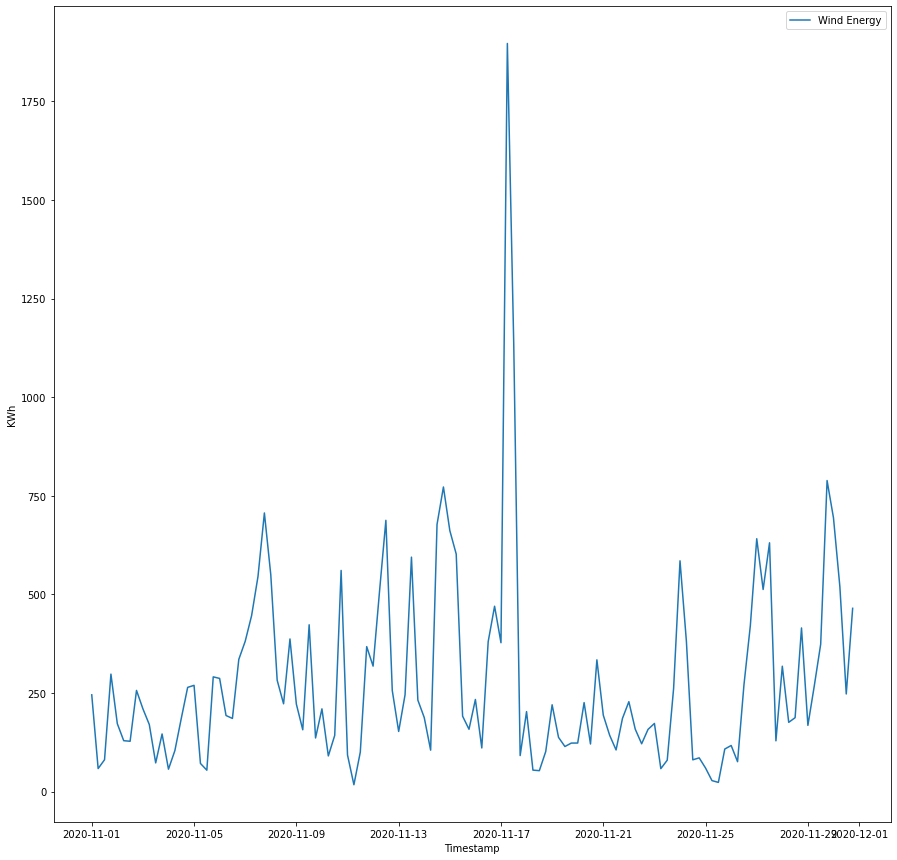

In [21]:
# Plotting line graphs for December 2017
figs, axs = plot_wind(wind_six_hour_df, wind_feature_units, (15,15))

# Energy Generation vs Energy Consumption annual graph

In [22]:
# Houses 4, 2, 3, and 15 belong to 4 separate clusters

In [23]:
consumption_df = pd.read_csv('Final Datasets/energy_consumption.csv')
consumption_df

Unnamed: 0            timestamp  energy_kWh  House Number  \
0                0  2012-06-01 01:00:00      1.0110             1   
1                1  2012-06-01 02:00:00      0.4510             1   
2                2  2012-06-01 03:00:00      0.5050             1   
3                3  2012-06-01 04:00:00      0.4410             1   
4                4  2012-06-01 05:00:00      0.4680             1   
...            ...                  ...         ...           ...   
611013      123761  2020-05-19 19:00:00      3.5802            28   
611014      123762  2020-05-19 20:00:00      3.4398            28   
611015      123763  2020-05-19 21:00:00      2.3049            28   
611016      123764  2020-05-19 22:00:00      2.4921            28   
611017      123765  2020-05-19 23:00:00      1.1817            28   

        electronics workbench energy  network equipment energy  \
0                           0.008686                  0.019316   
1                           0.007178                  0.019338   
2                           0.007324                  0.019336   
3                           0.007151                  0.019339   
4                           0.007224                  0.019338   
...                              ...                       ...   
611013                      0.028408                  0.038470   
611014                      0.027762                  0.038479   
611015                      0.022537                  0.038556   
611016                      0.023399                  0.038544   
611017                      0.017367                  0.038632   

        home office energy  RAE home office energy  \
0                 0.018232                0.134570   
1                 0.013745                0.061839   
2                 0.014177                0.068852   
3                 0.013664                0.060540   
4                 0.013881                0.064047   
...                    ...                     ...   
611013            0.069307                0.801381   
611014            0.067384                0.770210   
611015            0.051836                0.518247   
611016            0.054401                0.559808   
611017            0.036449                0.268881   

        RAE Mobile Phone Charger Energy  
0                              0.000431  
1                              0.000215  
2                              0.000236  
3                              0.000211  
4                              0.000221  
...                                 ...  
611013                         0.002441  
611014                         0.002348  
611015                         0.001601  
611016                         0.001724  
611017                         0.000861  

[611018 rows x 9 columns]

In [24]:
if 'Unnamed: 0' in consumption_df.columns:
    consumption_df.drop('Unnamed: 0',axis=1, inplace = True)

generation_df = pd.read_csv('Final Datasets/energy_generation.csv')
generation_df['Energy Generation'] = generation_df['Wind Energy'] + generation_df['Solar Energy']
generation_df = generation_df[['timestamp', 'Energy Generation']].set_index('timestamp')
generation_df

Energy Generation
timestamp                             
2012-01-01 00:00:00           0.168265
2012-01-01 01:00:00           0.168265
2012-01-01 02:00:00           0.168265
2012-01-01 03:00:00           0.168265
2012-01-01 04:00:00           0.168265
...                                ...
2020-12-31 19:00:00           1.710441
2020-12-31 20:00:00           1.710441
2020-12-31 21:00:00           1.497873
2020-12-31 22:00:00           1.285454
2020-12-31 23:00:00           1.286778

[78912 rows x 1 columns]

In [25]:
house_4 = consumption_df[consumption_df['House Number'] == 4][['timestamp', 'energy_kWh']]
house_2 = consumption_df[consumption_df['House Number'] == 2][['timestamp', 'energy_kWh']]
house_3 = consumption_df[consumption_df['House Number'] == 3][['timestamp', 'energy_kWh']]
house_15 = consumption_df[consumption_df['House Number'] == 15][['timestamp', 'energy_kWh']]

house_4= house_4[(house_4['timestamp'] <= '2018-01-01') & (house_4['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})

house_2= house_2[(house_2['timestamp'] <= '2018-01-01') & (house_2['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_3= house_3[(house_3['timestamp'] <= '2018-01-01') & (house_3['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_15= house_15[(house_15['timestamp'] <= '2018-01-01') & (house_15['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_15

Energy Consumption  Energy Generation
timestamp                                                 
2017-01-01 00:00:00                0.28           0.462231
2017-01-01 01:00:00                0.24           0.462231
2017-01-01 02:00:00                0.24           0.689978
2017-01-01 03:00:00                0.22           0.688715
2017-01-01 04:00:00                7.18           0.687452
...                                 ...                ...
2017-12-31 19:00:00                4.38           0.460539
2017-12-31 20:00:00                3.92           0.460539
2017-12-31 21:00:00                3.98           0.460539
2017-12-31 22:00:00                3.94           0.576104
2017-12-31 23:00:00                0.20           0.462231

[8729 rows x 2 columns]

In [26]:
house_4['timestamp'] = pd.to_datetime(house_4.index)
house_2['timestamp'] = pd.to_datetime(house_2.index)
house_3['timestamp'] = pd.to_datetime(house_3.index)
house_15['timestamp'] = pd.to_datetime(house_15.index)
house_4['timestamp'] = house_4['timestamp'] + pd.offsets.DateOffset(years=3)
house_2['timestamp'] = house_2['timestamp'] + pd.offsets.DateOffset(years=3)
house_3['timestamp'] = house_3['timestamp'] + pd.offsets.DateOffset(years=3)
house_15['timestamp'] = house_15['timestamp'] + pd.offsets.DateOffset(years=3)
house_4 = house_4.set_index('timestamp')
house_2 = house_2.set_index('timestamp')
house_3 = house_3.set_index('timestamp')
house_15 = house_15.set_index('timestamp')
house_4

Energy Consumption  Energy Generation
timestamp                                                 
2020-01-01 00:00:00                1.57           0.462231
2020-01-01 01:00:00                1.51           0.462231
2020-01-01 02:00:00                1.08           0.689978
2020-01-01 03:00:00                1.04           0.688715
2020-01-01 04:00:00                0.88           0.687452
...                                 ...                ...
2020-12-31 19:00:00                1.95           0.460539
2020-12-31 20:00:00                1.57           0.460539
2020-12-31 21:00:00                1.57           0.460539
2020-12-31 22:00:00                1.29           0.576104
2020-12-31 23:00:00                1.22           0.462231

[8745 rows x 2 columns]

Text(0, 0.5, 'kWh')

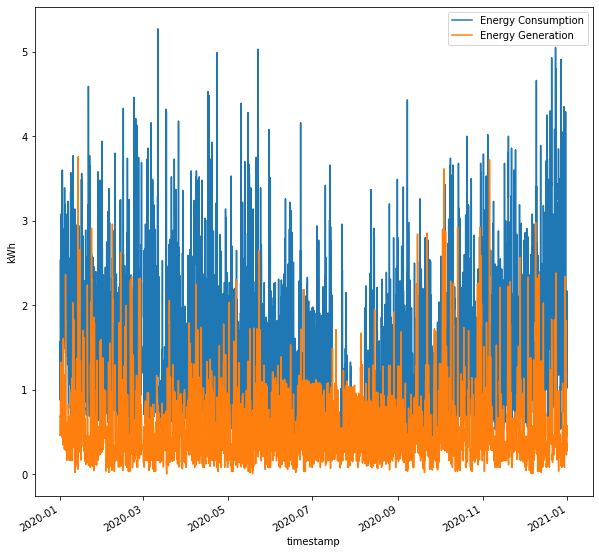

In [27]:
ax = house_4.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

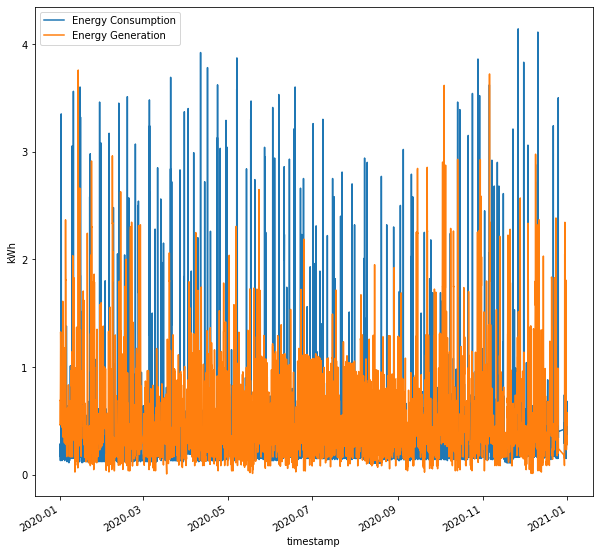

In [28]:
ax = house_2.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

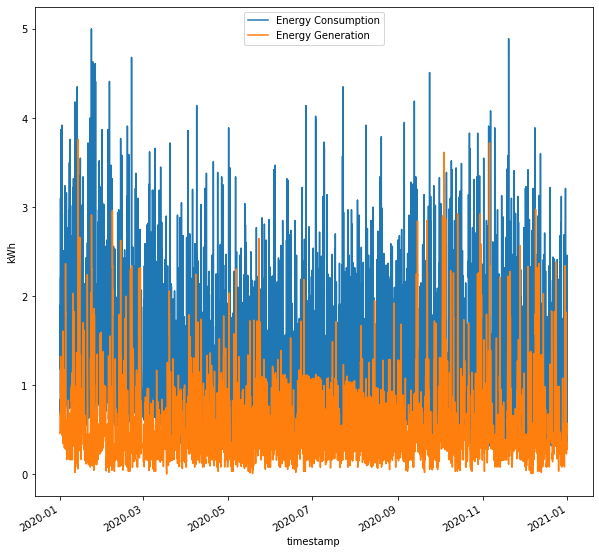

In [29]:
ax = house_3.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

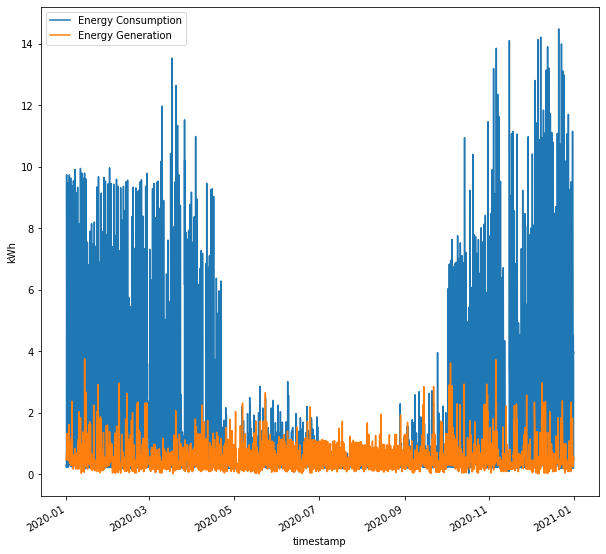

In [30]:
ax = house_15.plot(figsize=(10,10))
ax.set_ylabel('kWh')

In [31]:
house_4['ts'] = pd.to_datetime(house_4.index)
#house_4['ts'] = house_4['ts'] + pd.offsets.DateOffset(years=3)
house_4.set_index('ts', inplace=True)

house_2['ts'] = pd.to_datetime(house_2.index)
#house_2['ts'] = house_2['ts'] + pd.offsets.DateOffset(years=3)
house_2.set_index('ts', inplace=True)

house_3['ts'] = pd.to_datetime(house_3.index)
#house_3['ts'] = house_3['ts'] + pd.offsets.DateOffset(years=3)
house_3.set_index('ts', inplace=True)

house_15['ts'] = pd.to_datetime(house_15.index)
#house_15['ts'] = house_15['ts'] + pd.offsets.DateOffset(years=3)
house_15.set_index('ts', inplace=True)

house_15

Energy Consumption  Energy Generation
ts                                                        
2020-01-01 00:00:00                0.28           0.462231
2020-01-01 01:00:00                0.24           0.462231
2020-01-01 02:00:00                0.24           0.689978
2020-01-01 03:00:00                0.22           0.688715
2020-01-01 04:00:00                7.18           0.687452
...                                 ...                ...
2020-12-31 19:00:00                4.38           0.460539
2020-12-31 20:00:00                3.92           0.460539
2020-12-31 21:00:00                3.98           0.460539
2020-12-31 22:00:00                3.94           0.576104
2020-12-31 23:00:00                0.20           0.462231

[8729 rows x 2 columns]

In [32]:
# Resampling to daily values
house_4_daily = house_4.resample('D').sum()
house_2_daily = house_2.resample('D').sum()
house_3_daily = house_3.resample('D').sum()
house_15_daily = house_15.resample('D').sum()
house_4_daily

Energy Consumption  Energy Generation
ts                                               
2020-01-01               43.40          19.422454
2020-01-02               54.41          18.228269
2020-01-03               45.50          17.220156
2020-01-04               56.63          15.468864
2020-01-05               50.39          20.909048
...                        ...                ...
2020-12-27               53.58           6.046977
2020-12-28               52.00           7.521295
2020-12-29               42.64           6.234746
2020-12-30               38.50          21.432941
2020-12-31               40.41          15.667253

[366 rows x 2 columns]

Text(0, 0.5, 'kWh')

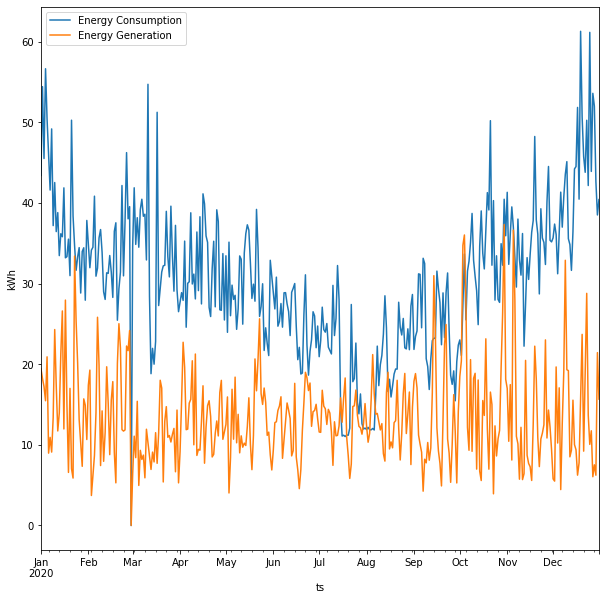

In [33]:
ax = house_4_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

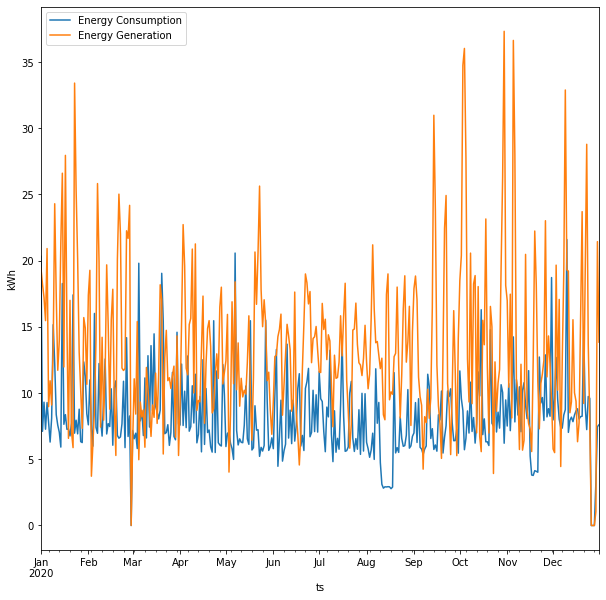

In [34]:
ax = house_2_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

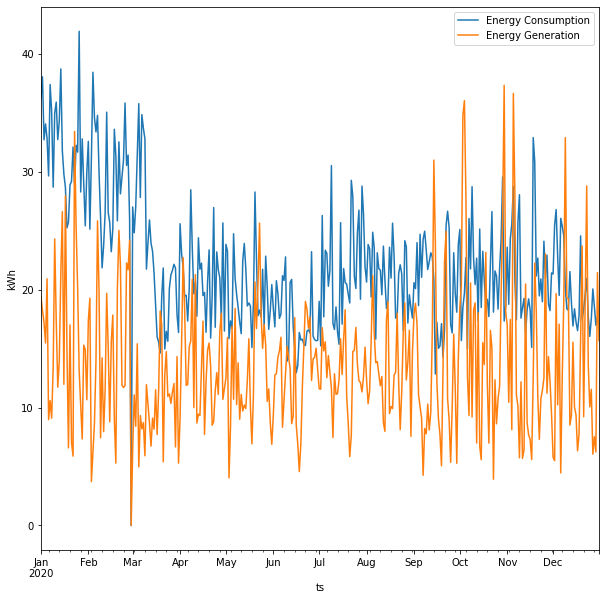

In [35]:
ax = house_3_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

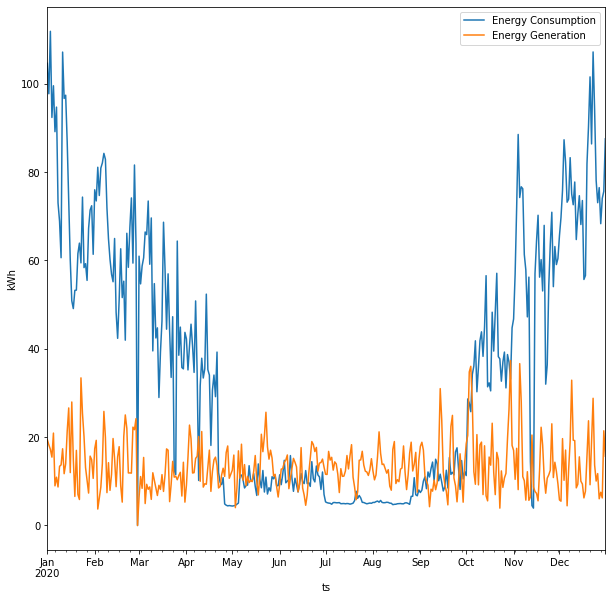

In [36]:
ax = house_15_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

In [37]:
# Resampling to Weekly values

In [38]:
house_4_weekly = house_4.resample('W').sum()
house_2_weekly = house_2.resample('W').sum()
house_3_weekly = house_3.resample('W').sum()
house_15_weekly = house_15.resample('W').sum()
#house_4_weekly

Text(0, 0.5, 'kWh')

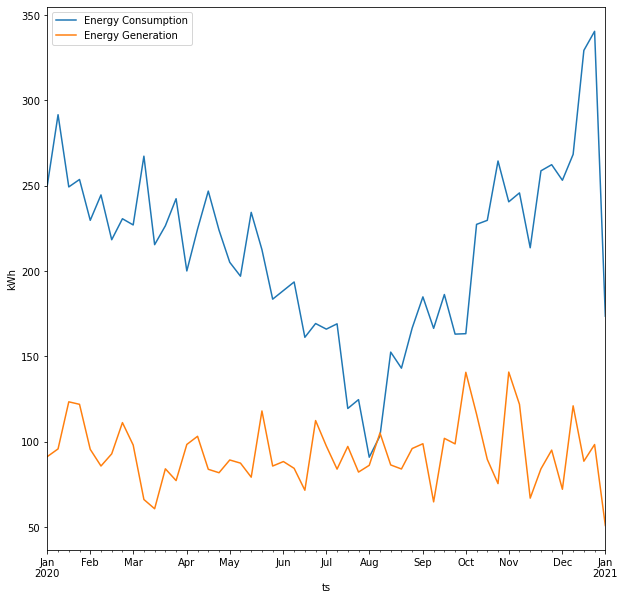

In [39]:
ax = house_4_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

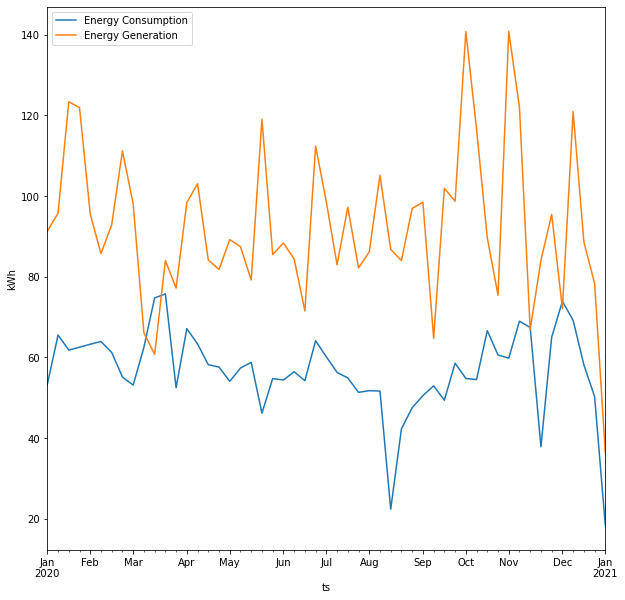

In [40]:
ax = house_2_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

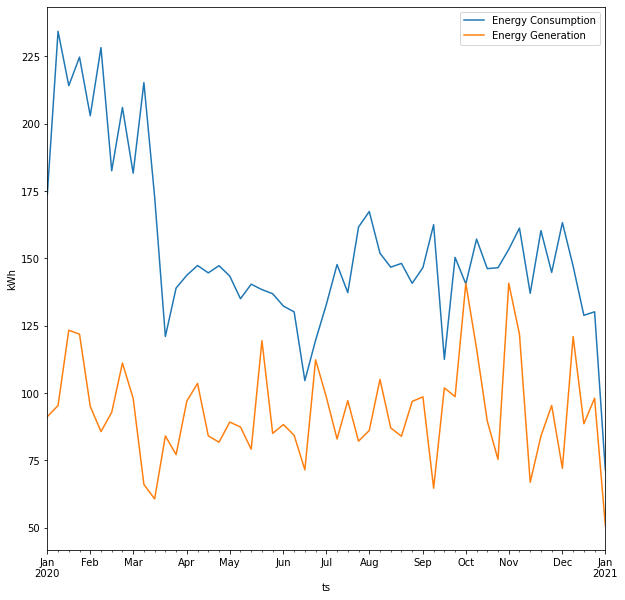

In [41]:
ax = house_3_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

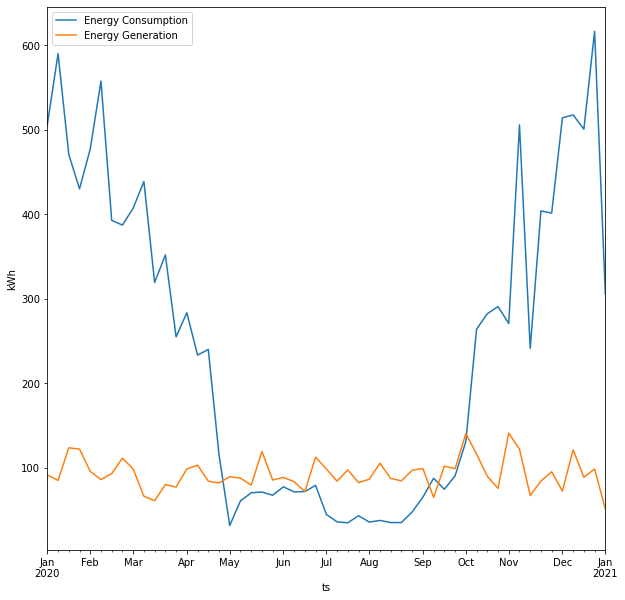

In [42]:
ax = house_15_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

## Energy Generation vs Energy Consumption graph for a month

In [43]:
house_4 = consumption_df[consumption_df['House Number'] == 4][['timestamp', 'energy_kWh']]
house_2 = consumption_df[consumption_df['House Number'] == 2][['timestamp', 'energy_kWh']]
house_3 = consumption_df[consumption_df['House Number'] == 3][['timestamp', 'energy_kWh']]
house_15 = consumption_df[consumption_df['House Number'] == 15][['timestamp', 'energy_kWh']]

house_4= house_4[(house_4['timestamp'] <= '2017-12-01') & (house_4['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_2= house_2[(house_2['timestamp'] <= '2017-12-01') & (house_2['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_3= house_3[(house_3['timestamp'] <= '2017-12-01') & (house_3['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_15= house_15[(house_15['timestamp'] <= '2017-12-01') & (house_15['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})

house_4['ts'] = pd.to_datetime(house_4.index)
house_4['ts'] = house_4['ts'] + pd.offsets.DateOffset(years=3)
house_4.set_index('ts', inplace=True)

house_2['ts'] = pd.to_datetime(house_2.index)
house_2['ts'] = house_2['ts'] + pd.offsets.DateOffset(years=3)
house_2.set_index('ts', inplace=True)

house_3['ts'] = pd.to_datetime(house_3.index)
house_3['ts'] = house_3['ts'] + pd.offsets.DateOffset(years=3)
house_3.set_index('ts', inplace=True)

house_15['ts'] = pd.to_datetime(house_15.index)
house_15['ts'] = house_15['ts'] + pd.offsets.DateOffset(years=3)
house_15.set_index('ts', inplace=True)

house_4

Energy Consumption  Energy Generation
ts                                                        
2020-11-01 00:00:00                0.90           0.448233
2020-11-01 01:00:00                0.77           0.449032
2020-11-01 02:00:00                0.83           0.670275
2020-11-01 03:00:00                0.87           0.670275
2020-11-01 04:00:00                1.01           0.954356
...                                 ...                ...
2020-11-30 19:00:00                1.65           0.563677
2020-11-30 20:00:00                1.35           0.284805
2020-11-30 21:00:00                1.44           0.284805
2020-11-30 22:00:00                1.30           0.368533
2020-11-30 23:00:00                1.05           0.283785

[720 rows x 2 columns]

In [44]:
# Resample to 4 hours
house_4_4h = house_4.resample('4H').sum()
house_2_4h = house_2.resample('4H').sum()
house_3_4h= house_3.resample('4H').sum()
house_15_4h = house_15.resample('4H').sum()

Text(0, 0.5, 'kWh')

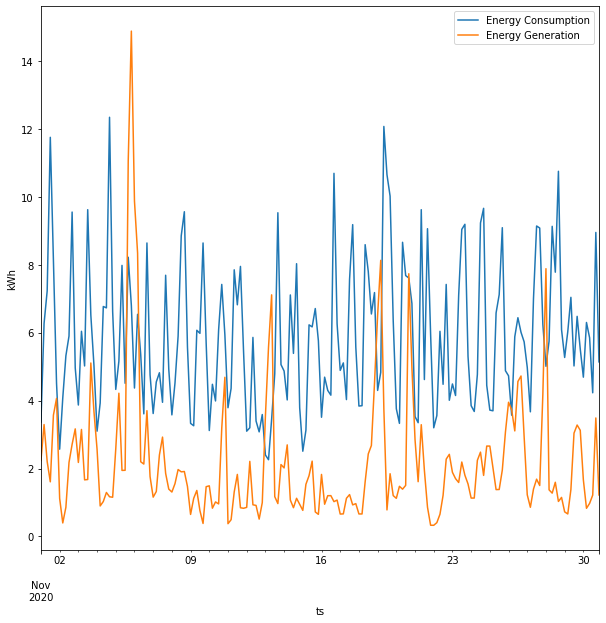

In [45]:
ax = house_4_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

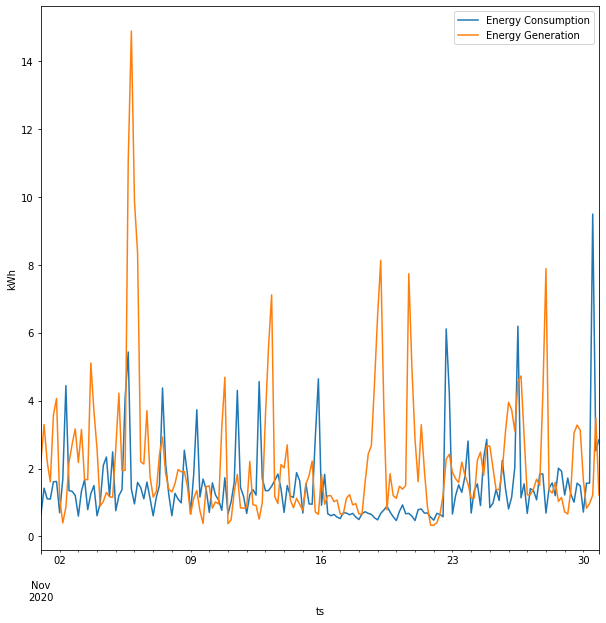

In [46]:
ax = house_2_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

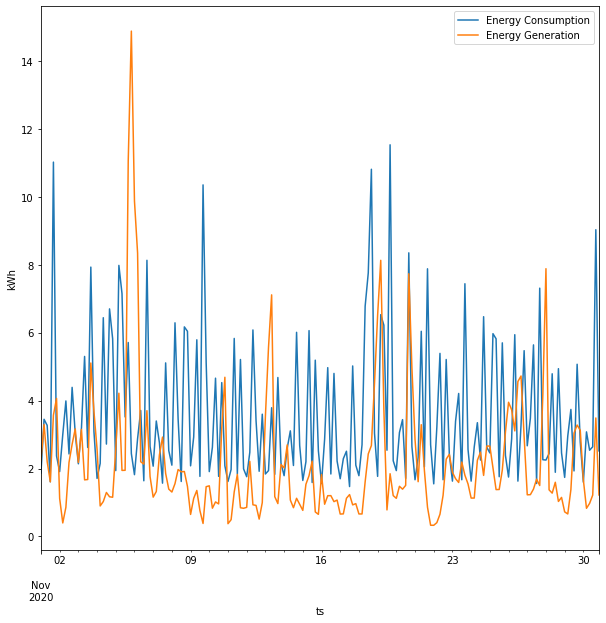

In [47]:
ax = house_3_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

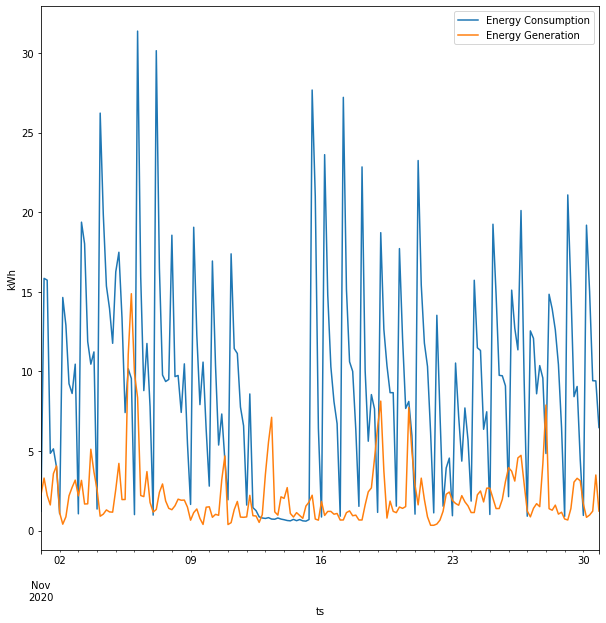

In [48]:
ax = house_15_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

In [49]:
# Resample to 1 day
house_4 = house_4.resample('D').sum()
house_2 = house_2.resample('D').sum()
house_3= house_3.resample('D').sum()
house_15 = house_15.resample('D').sum()

Text(0, 0.5, 'kWh')

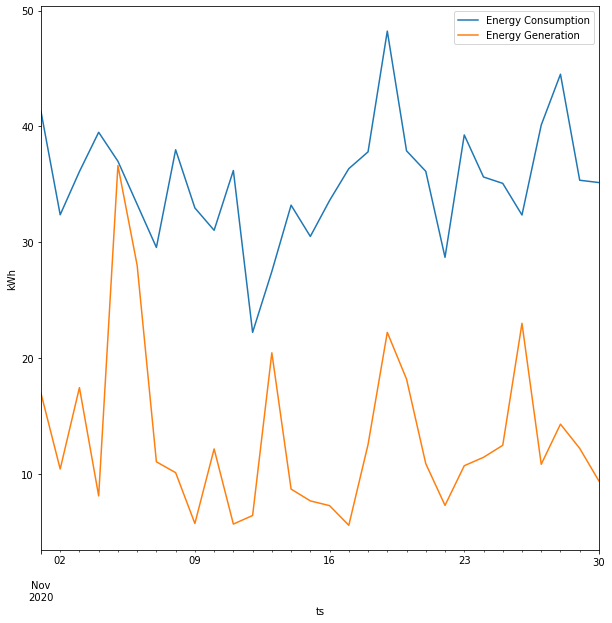

In [50]:
ax = house_4.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

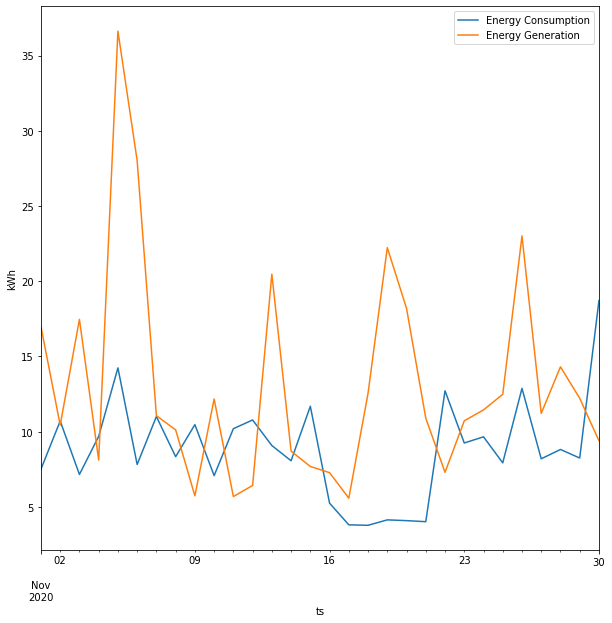

In [51]:
ax = house_2.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

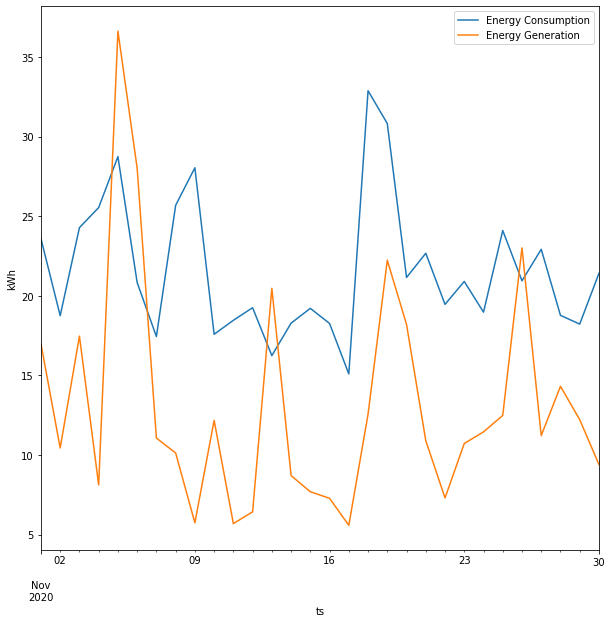

In [52]:
ax = house_3.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

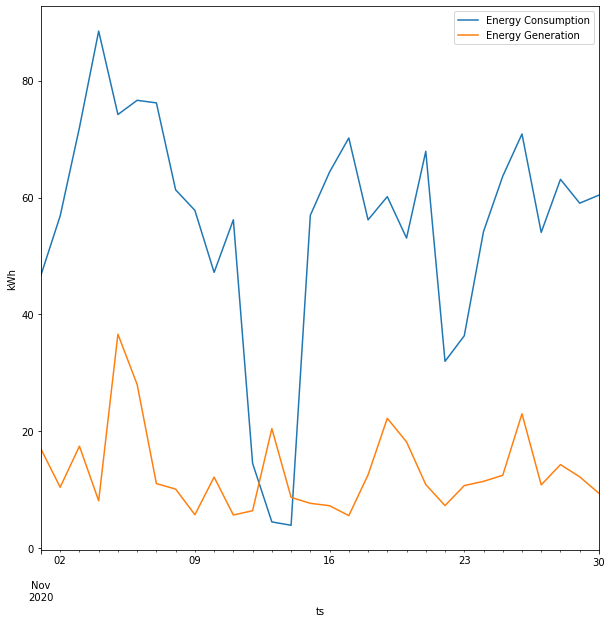

In [53]:
ax = house_15.plot(figsize=(10,10))
ax.set_ylabel('kWh')

# Wind Energy vs Solar Energy Generation annual graph

In [54]:
generation_df = pd.read_csv('Final Datasets/energy_generation.csv')
generation_df = generation_df[(generation_df['timestamp'] <= '2021-01-01') & (generation_df['timestamp'] >= '2020-01-01')].set_index('timestamp')

In [55]:
#generation_df

Text(0, 0.5, 'kWh')

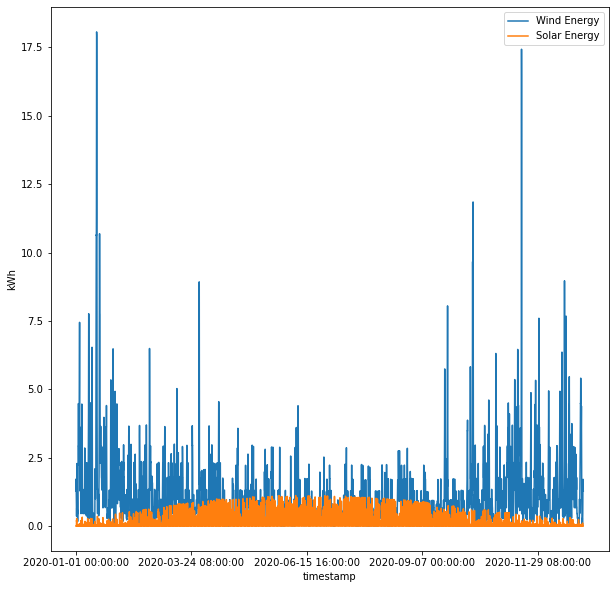

In [56]:
ax = generation_df.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

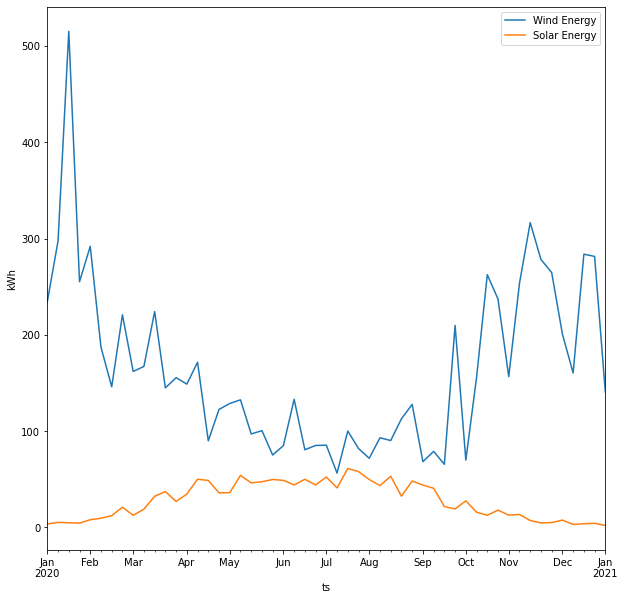

In [57]:
generation_df['ts'] = pd.to_datetime(generation_df.index)
generation_df.set_index('ts', inplace=True)

# Resample to 1 week

generation_df = generation_df.resample('W').sum()
ax = generation_df.plot(figsize=(10,10))
ax.set_ylabel('kWh')

## Wind Energy vs Solar Energy Generation graph for a month

In [62]:
generation_df = pd.read_csv('Final Datasets/energy_generation.csv')
generation_df = generation_df[(generation_df['timestamp'] <= '2020-12-01') & (generation_df['timestamp'] >= '2020-11-01')].set_index('timestamp')

In [63]:
generation_df['ts'] = pd.to_datetime(generation_df.index)
generation_df.set_index('ts', inplace=True)
generation_df

Wind Energy  Solar Energy
ts                                            
2020-11-01 00:00:00     0.971944           0.0
2020-11-01 01:00:00     1.555929           0.0
2020-11-01 02:00:00     1.777819           0.0
2020-11-01 03:00:00     1.778226           0.0
2020-11-01 04:00:00     1.336724           0.0
...                          ...           ...
2020-11-30 19:00:00     2.973838           0.0
2020-11-30 20:00:00     2.976720           0.0
2020-11-30 21:00:00     2.979601           0.0
2020-11-30 22:00:00     2.662279           0.0
2020-11-30 23:00:00     2.345666           0.0

[720 rows x 2 columns]

Text(0, 0.5, 'kWh')

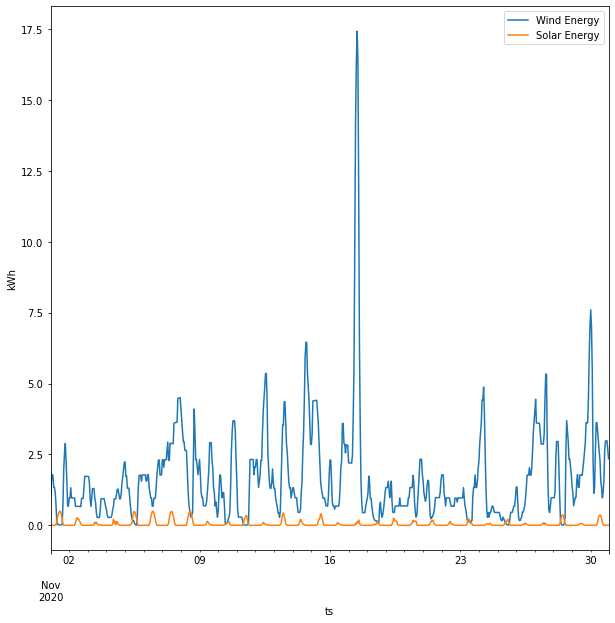

In [64]:
ax = generation_df.plot(figsize=(10,10))
ax.set_ylabel('kWh')

# Comparing scenarios against real energy consumption for a house in each cluster

In [61]:
# all_cluster_results_file = open("Models/Scenario2/Objects/all_cluster_results.pickle", "rb")
# all_cluster_results = pickle.load( all_cluster_results_file)
# all_cluster_results_file.close()


# scenario_4_all_cluster_results_file = open("Models/Scenario4/Objects/all_cluster_results.pickle", "rb")
# scenario_4_all_cluster_results=pickle.load(scenario_4_all_cluster_results_file)
# scenario_4_all_cluster_results_file.close()